# Exploratory Data Analysis for All Documents

In this notebook, we perform exploratory data analysis (EDA) to gain insights into our dataset. Our goal is to guide model selection, optimize algorithm performance, and determine whether we can improve efficiency—such as by reducing the input text length (e.g., using only the introduction and conclusion) while maintaining classification accuracy. We also analyze term importance using TF-IDF and similarity metrics to explore rule-based or hybrid approaches.

## Importing all Required Libraries

In [1]:
from collections import Counter
from collections import defaultdict
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns
import spacy

## **Load and Combine Data by Topic**

In [2]:
import os
from collections import defaultdict
import pandas as pd
# Path to main data folder
main_directory = "Cleaned_Data_v2"

# Dictionary to store text grouped by main topics
data = defaultdict(list)

# Traverse the folder structure
for main_topic in os.listdir(main_directory):
    main_topic_path = os.path.join(main_directory, main_topic)
    if os.path.isdir(main_topic_path):  # Ensure it's a directory
        for root, _, files in os.walk(main_topic_path):  # Walk through all subfolders
            for file in files:
                if file.endswith(".txt"):  # Only process .txt files
                    file_path = os.path.join(root, file)
                    with open(file_path, "r", encoding="utf-8") as f:
                        content = f.read()
                        data[main_topic].append(content)

# Combine all text files under each main topic into a single string
combined_texts = {topic: " ".join(contents) for topic, contents in data.items()}


In [3]:
import os
print(os.getcwd())


/Users/ivan/Documents/University/Y4S2/FYP/Week 3


## **Generate Unigrams, Bigrams, Trigrams for each topic**

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

# Function to generate n-grams
def generate_ngrams(corpus, ngram_range=(1, 1), top_n=20):
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    ngram_matrix = vectorizer.fit_transform([corpus])
    ngram_counts = ngram_matrix.toarray().sum(axis=0)
    ngram_features = vectorizer.get_feature_names_out()

    # Create a DataFrame of n-grams and their counts
    ngram_df = pd.DataFrame({"N-gram": ngram_features, "Count": ngram_counts})
    ngram_df = ngram_df.sort_values(by="Count", ascending=False).head(top_n)
    return ngram_df

# Generate n-grams for each topic
ngram_results = {}
for topic, text in combined_texts.items():
    print(f"\nTopic: {topic}")
    print("Unigrams:")
    print(generate_ngrams(text, ngram_range=(1, 1)))
    print("\nBigrams:")
    print(generate_ngrams(text, ngram_range=(2, 2)))
    print("\nTrigrams:")
    print(generate_ngrams(text, ngram_range=(3, 3)))



Topic: Marketing and Public Communication
Unigrams:
               N-gram  Count
78                 ai    100
1446          loyalty    100
1489        marketing     82
493           content     81
438         companies     79
588              data     78
576         customers     76
574          customer     75
1877         programs     71
1763  personalization     63
1055            genai     58
544          creative     53
2586              use     52
1766     personalized     47
285            boston     42
490         consumers     41
487        consulting     41
1876          program     41
24             across     40
1370          leaders     40

Bigrams:
                       N-gram  Count
861         boston consulting     38
1459         consulting group     38
4320         loyalty programs     33
4319          loyalty program     29
4405        managing director     21
6481              see exhibit     18
5386         personalized ers     17
4502  marketing organizations   

In [20]:
# Save n-gram results for each topic
for topic, text in combined_texts.items():
    for n, ngram_range in [(1, (1, 1)), (2, (2, 2)), (3, (3, 3))]:
        ngram_df = generate_ngrams(text, ngram_range=ngram_range)
        ngram_df.to_csv(f"{topic}_ngrams_{n}.csv", index=False)


## **Generate Bar Charts for N-grams**

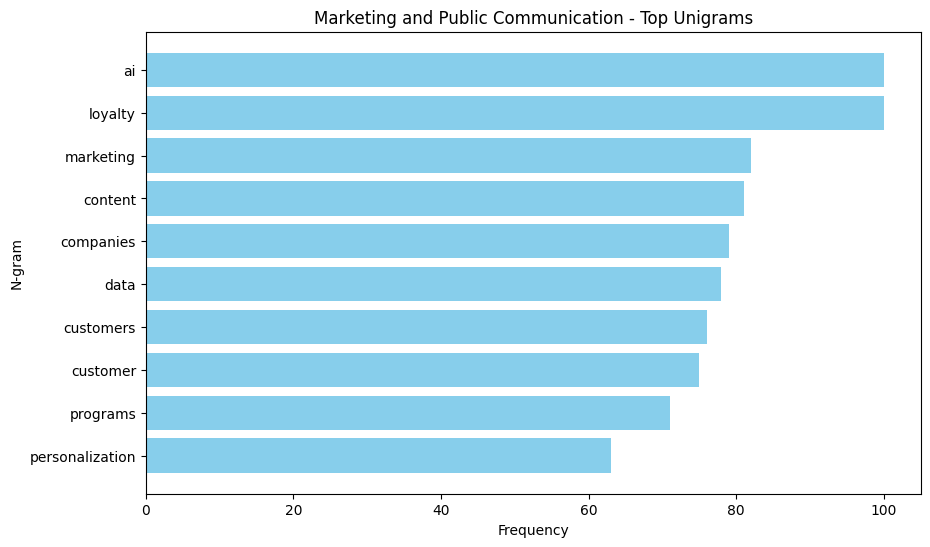

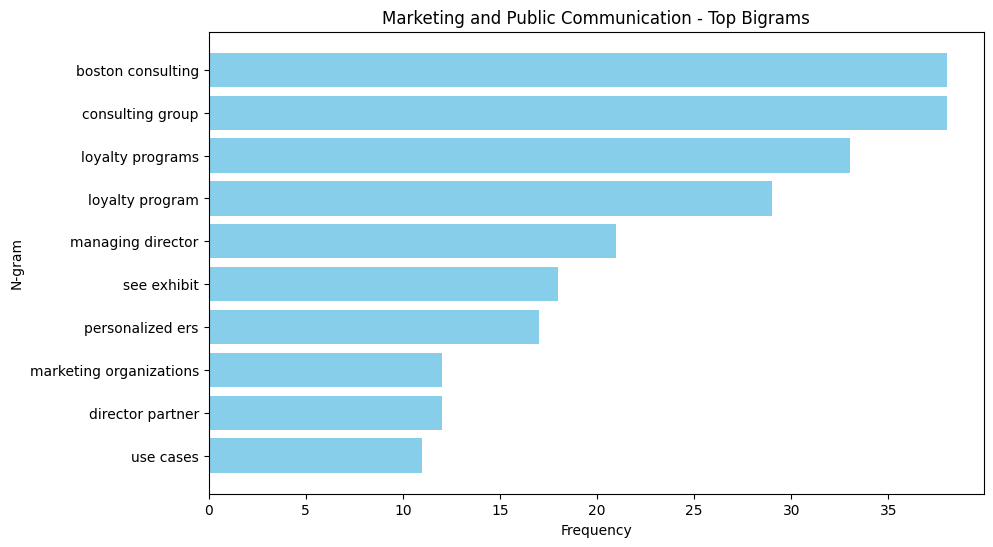

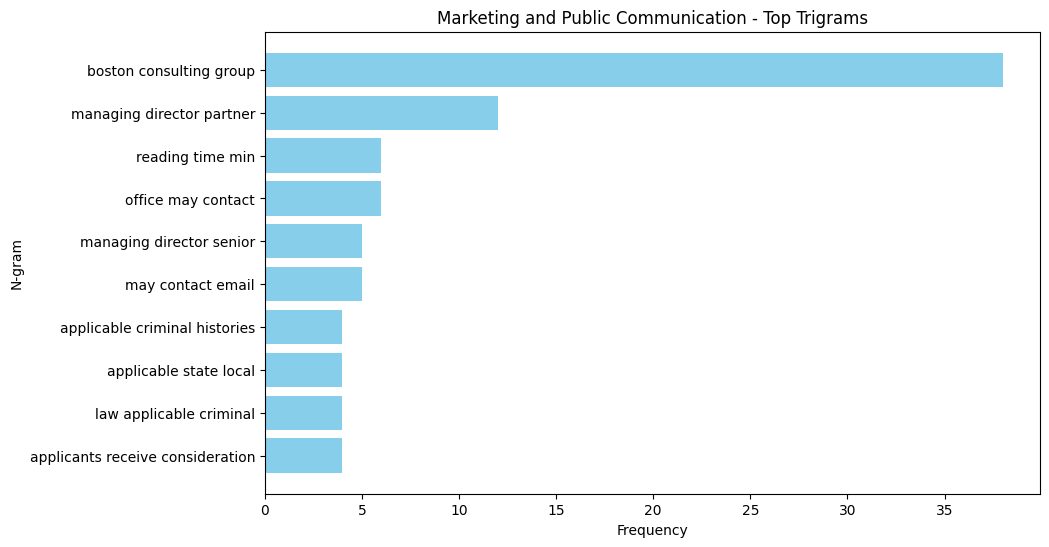

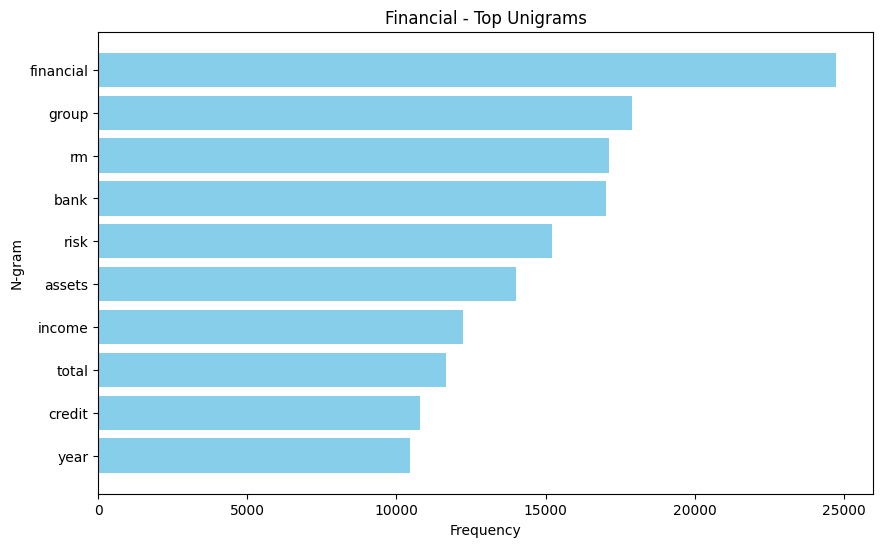

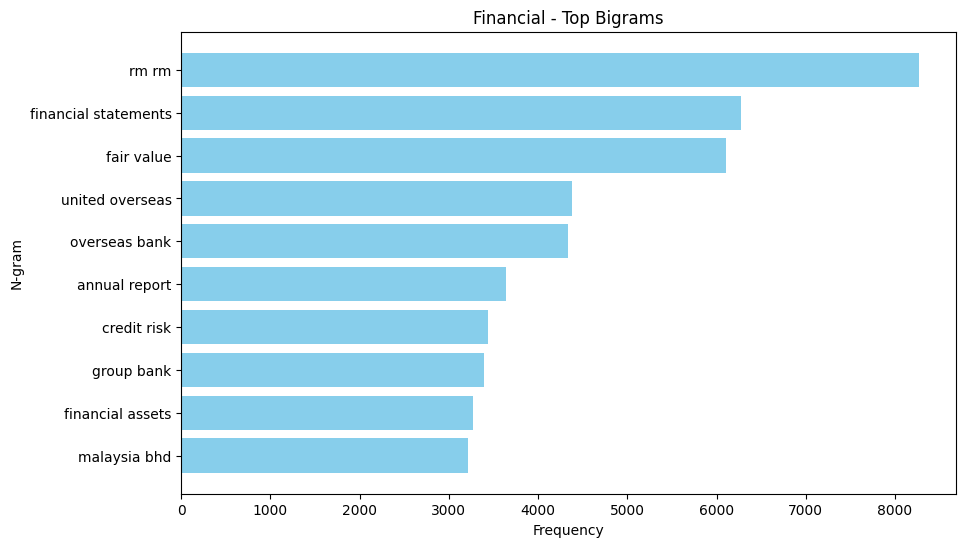

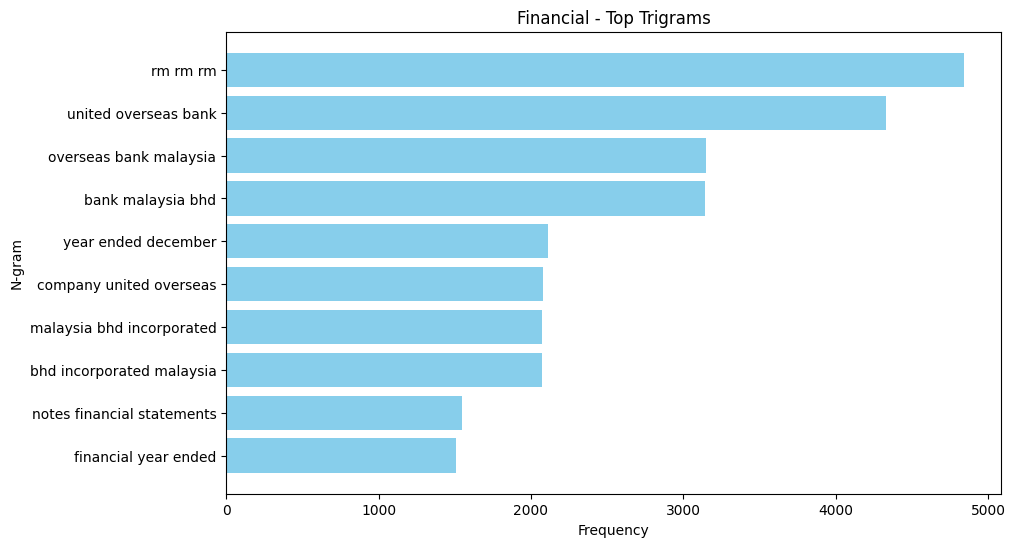

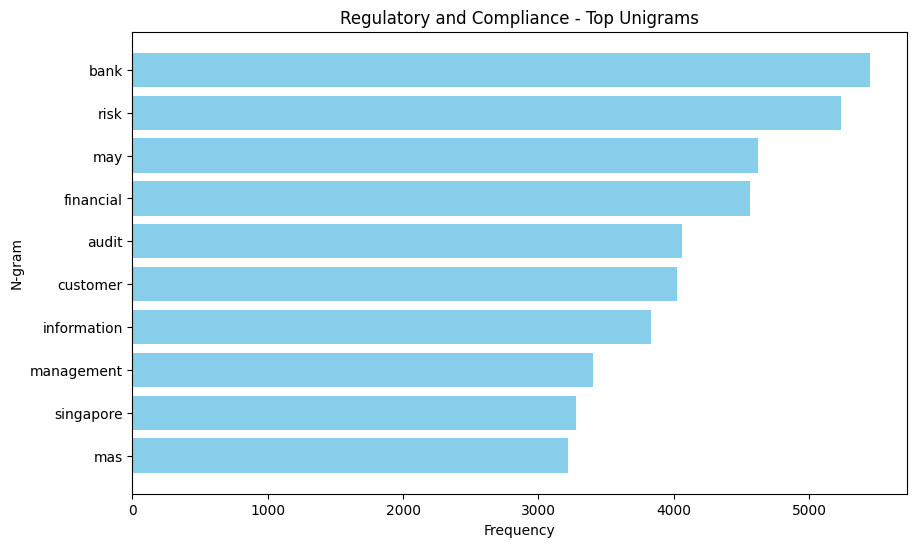

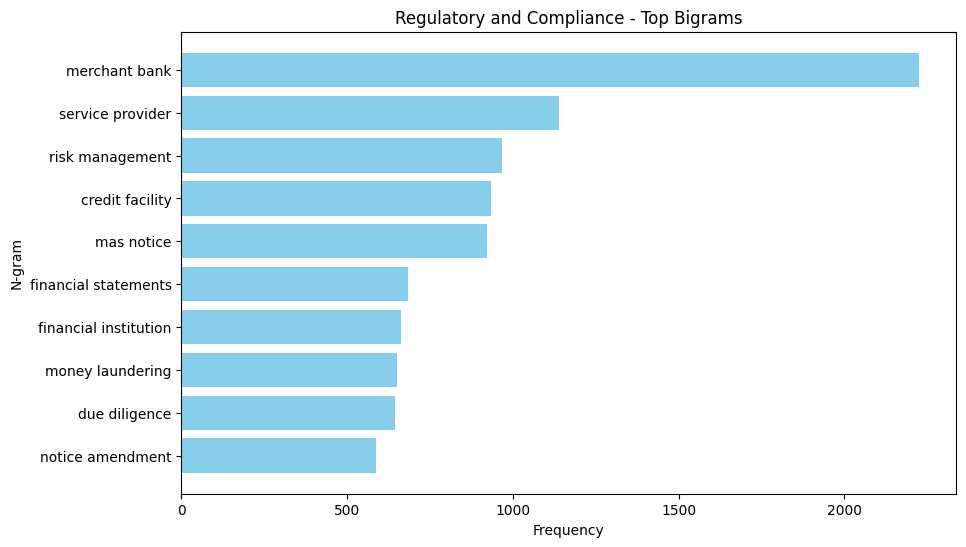

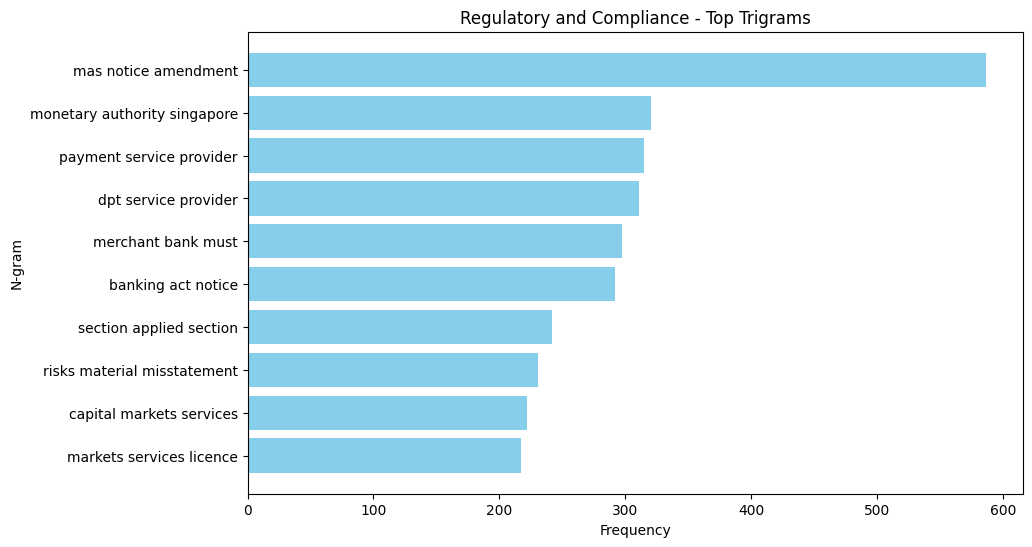

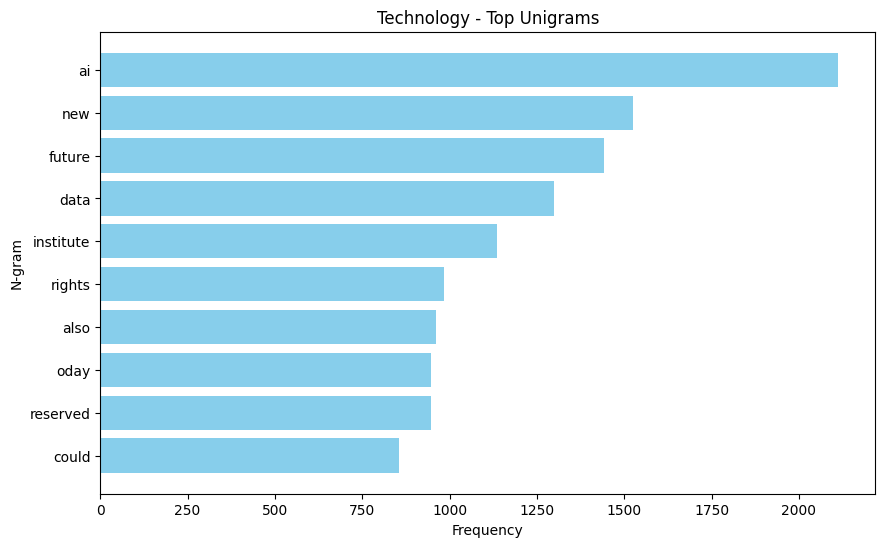

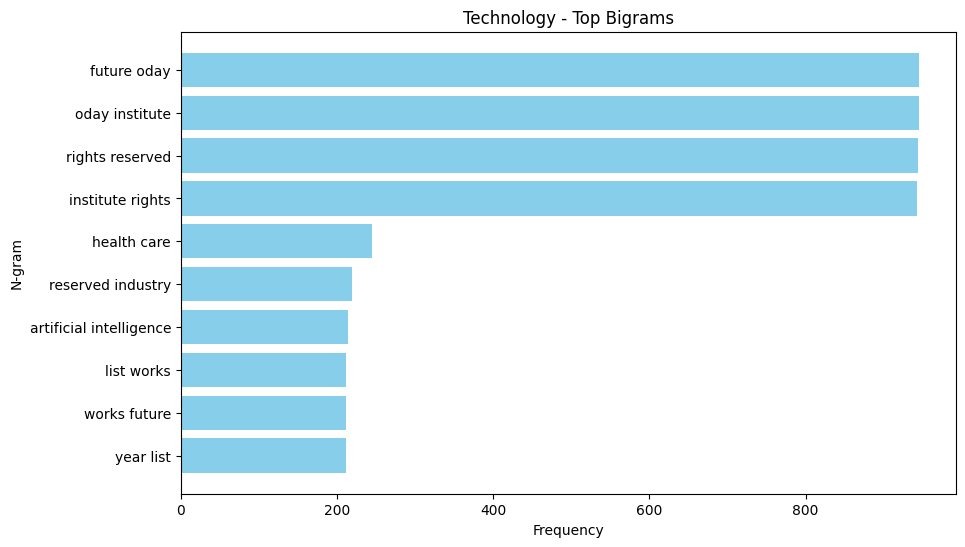

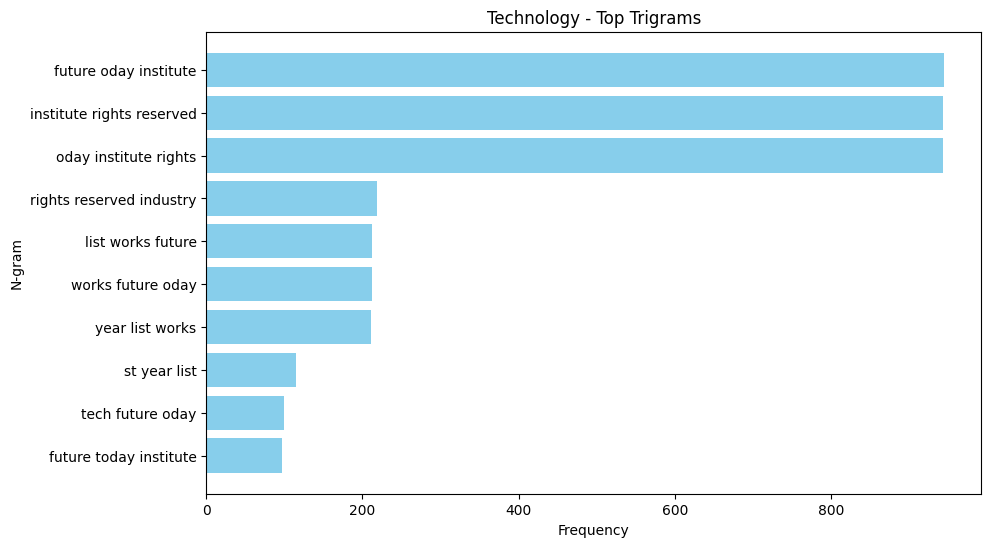

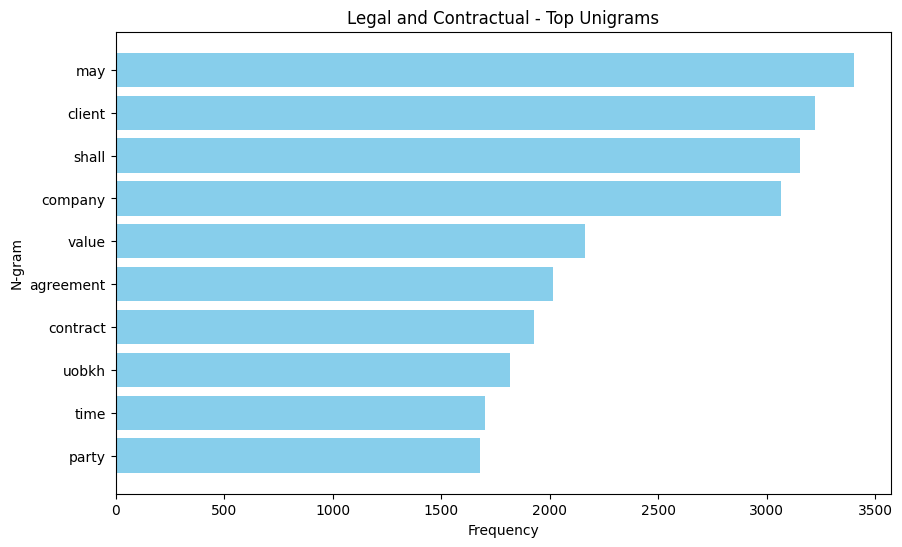

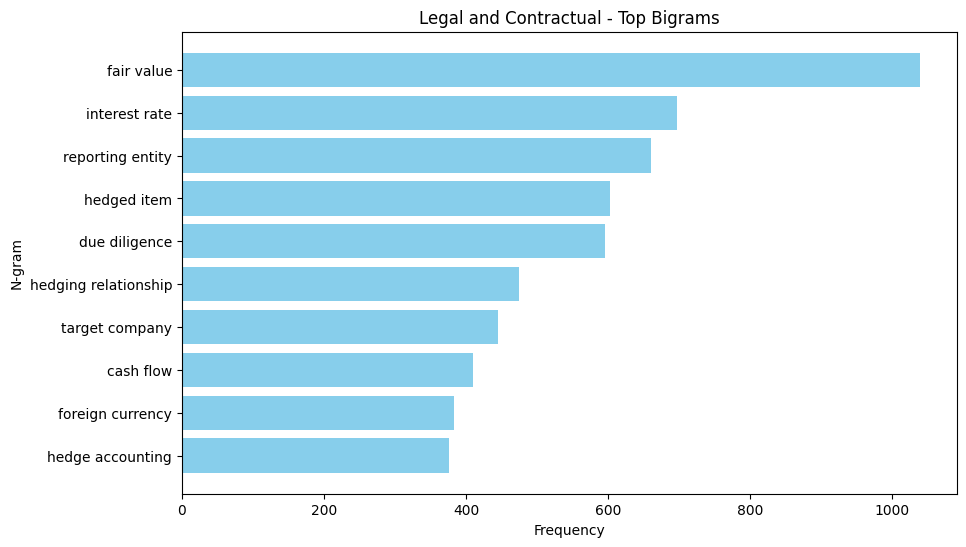

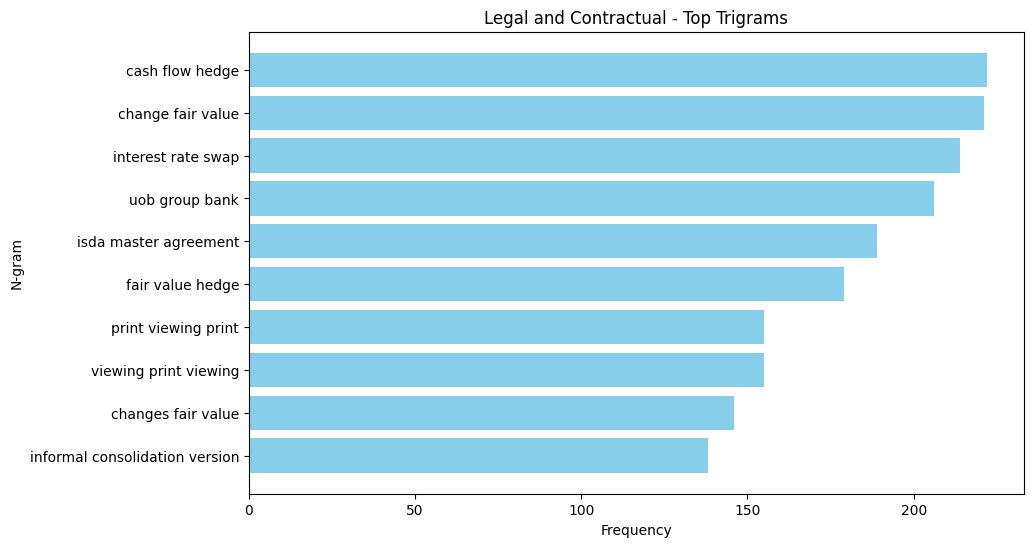

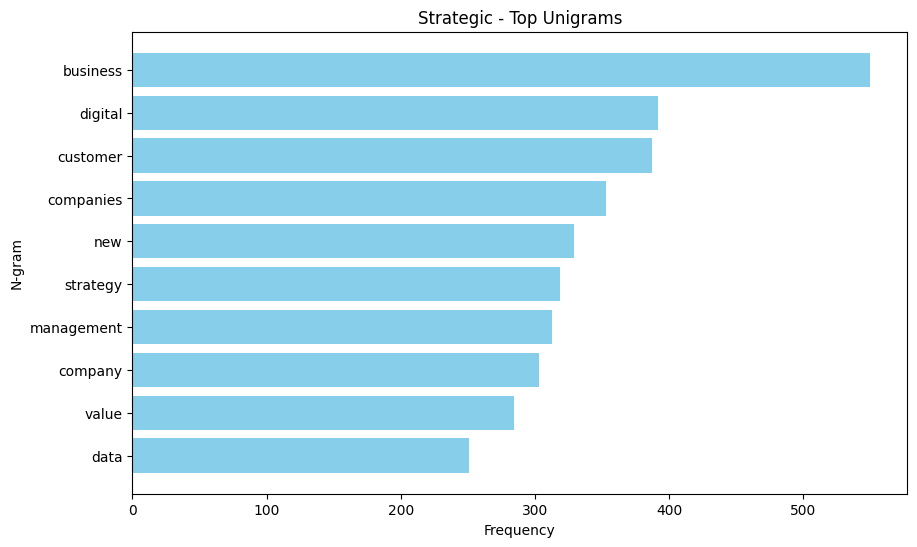

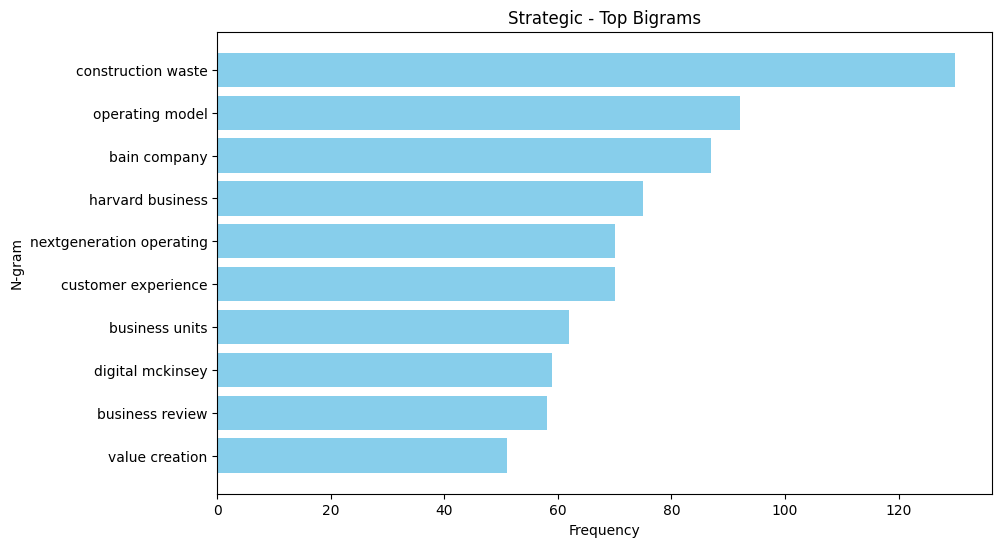

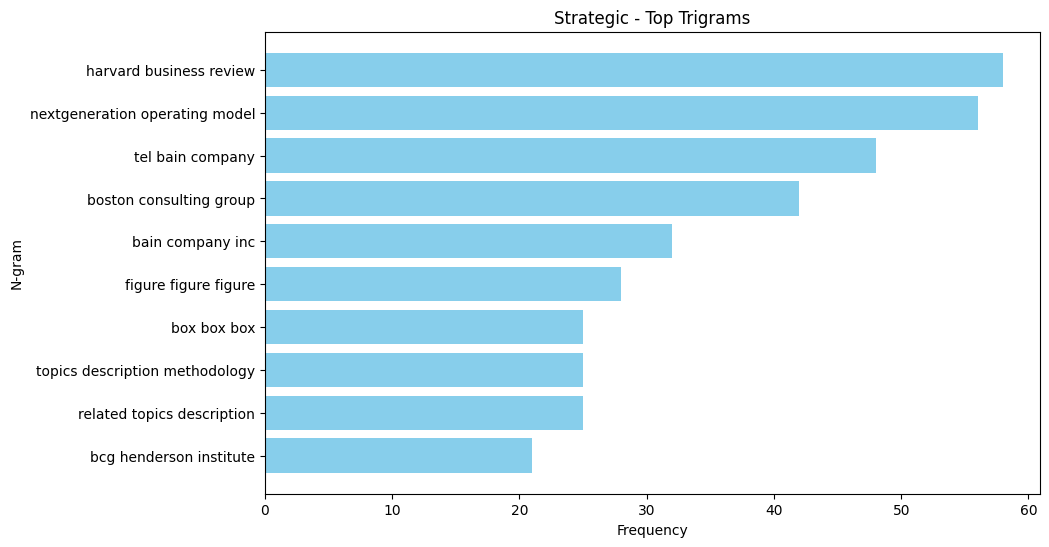

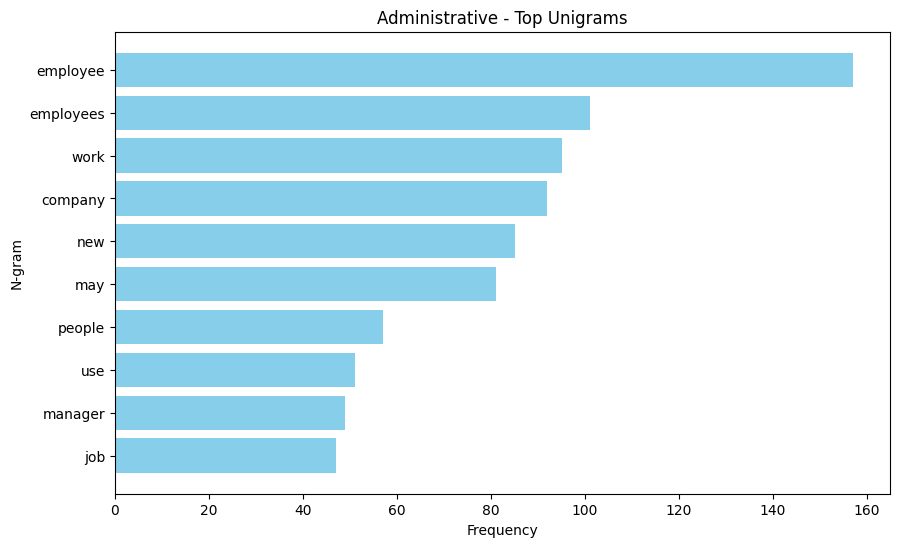

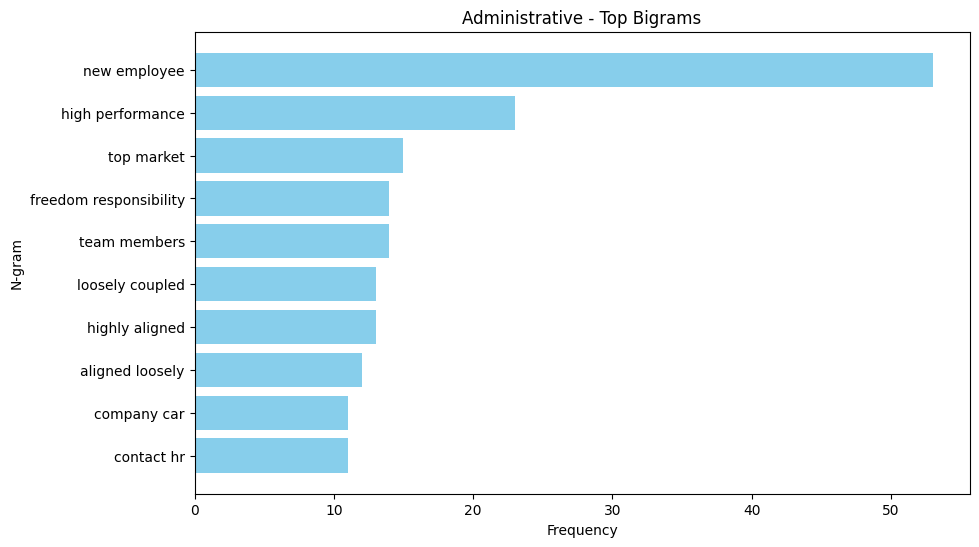

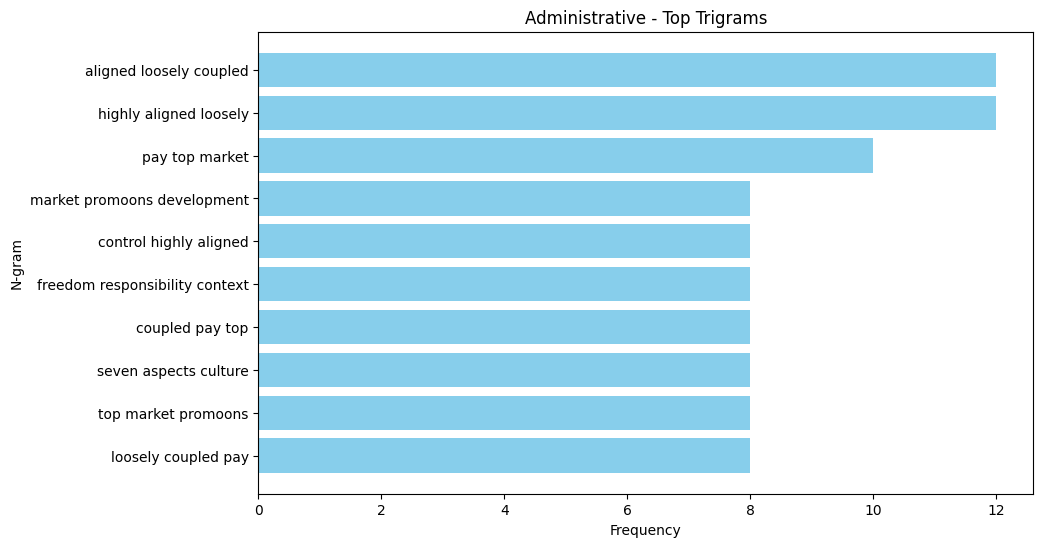

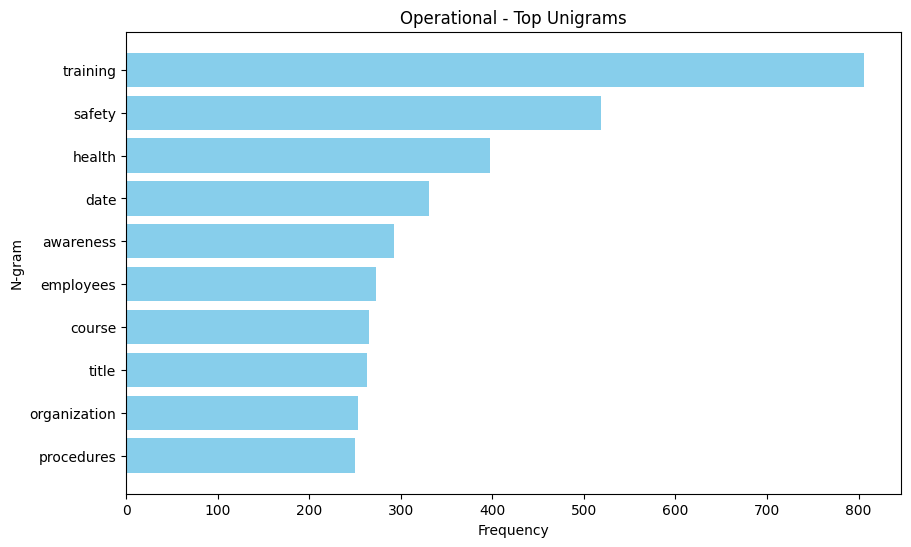

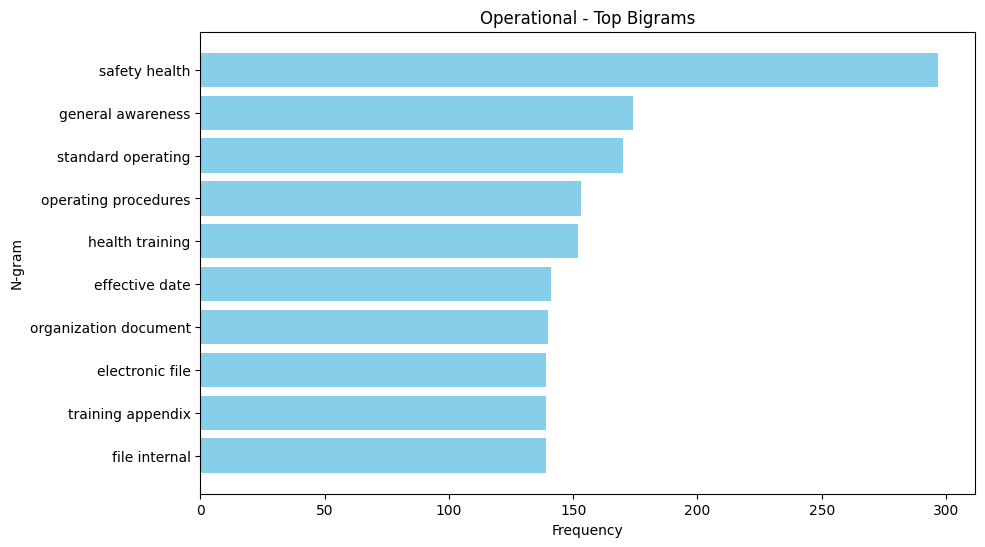

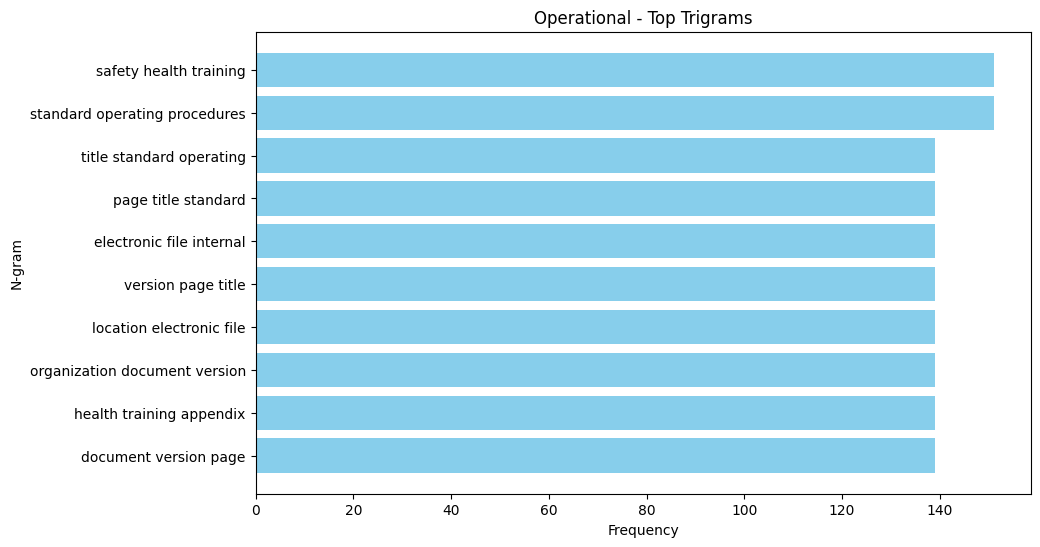

In [21]:
import matplotlib.pyplot as plt

# Function to generate bar charts for n-grams
def plot_ngrams(ngram_df, title, top_n=10):
    plt.figure(figsize=(10, 6))
    plt.barh(ngram_df['N-gram'][:top_n], ngram_df['Count'][:top_n], color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('N-gram')
    plt.title(title)
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest count on top
    plt.show()

# Generate and plot n-grams for each topic
for topic, text in combined_texts.items():
    for n, ngram_range, title_suffix in [(1, (1, 1), "Unigrams"), (2, (2, 2), "Bigrams"), (3, (3, 3), "Trigrams")]:
        ngram_df = generate_ngrams(text, ngram_range=ngram_range, top_n=10)
        plot_ngrams(ngram_df, title=f"{topic} - Top {title_suffix}")


## **Generate Wordclouds**

## Aggregated Word Cloud

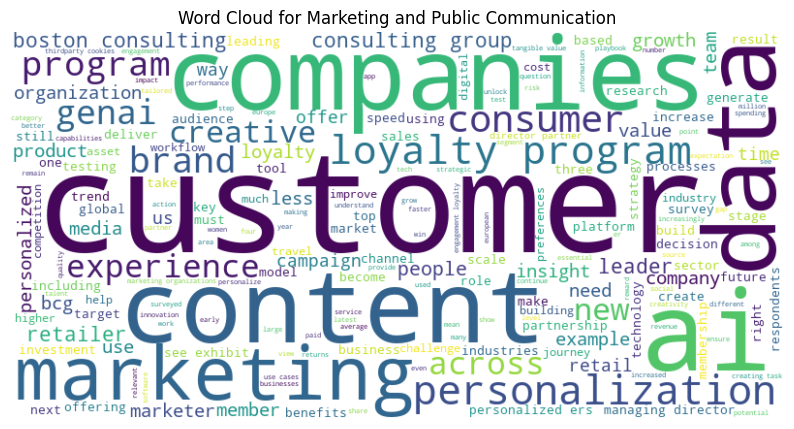

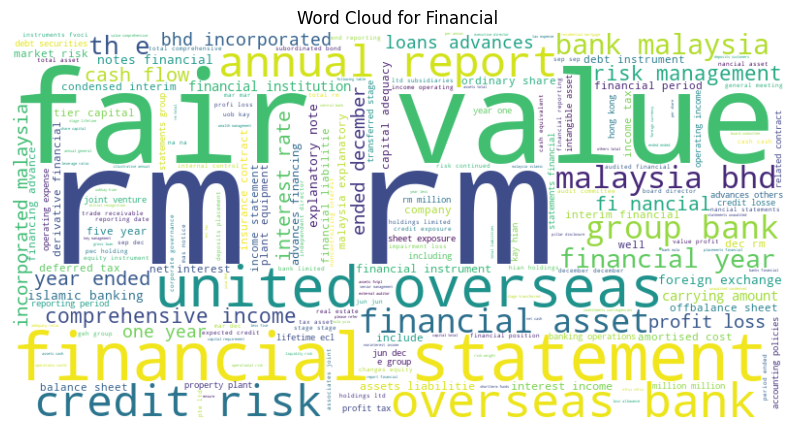

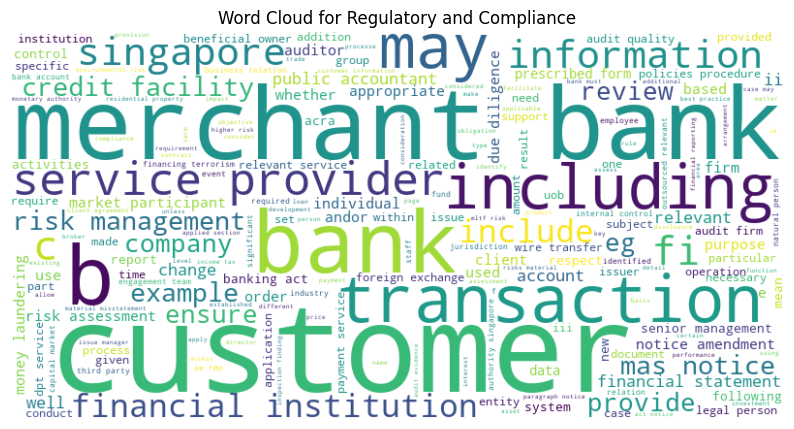

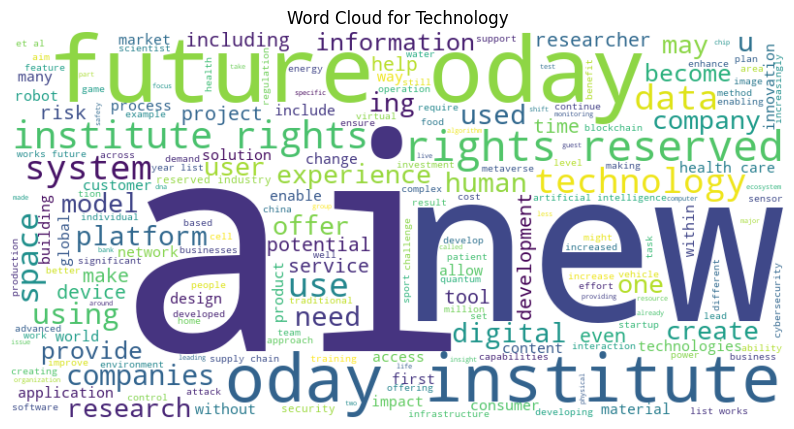

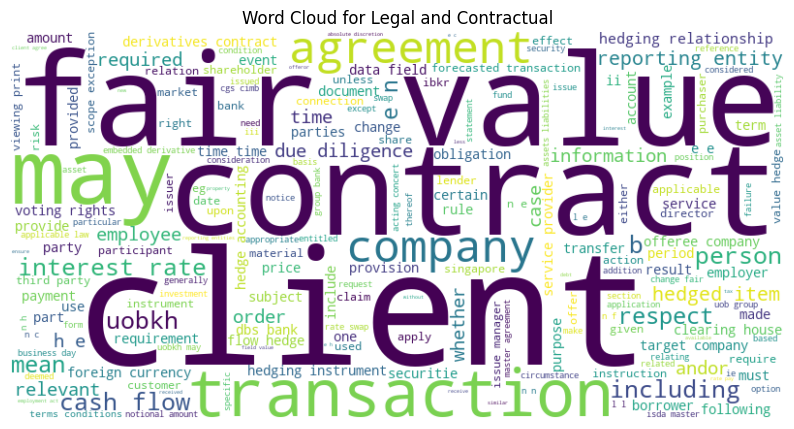

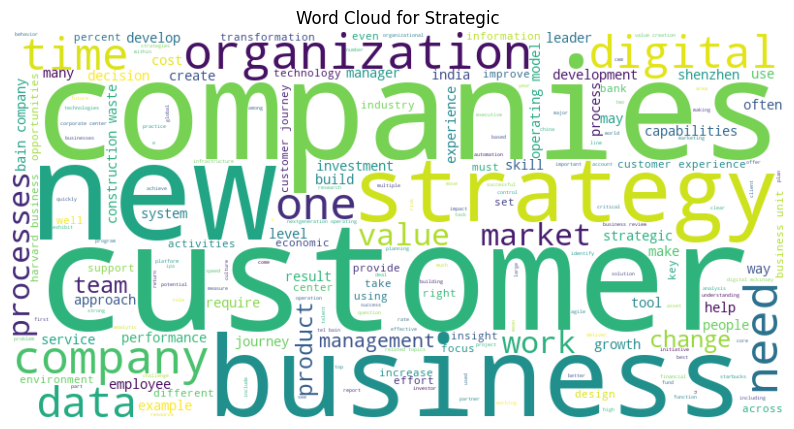

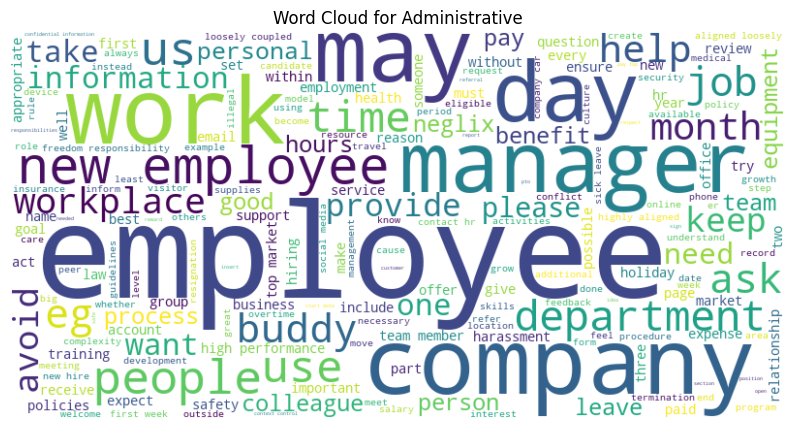

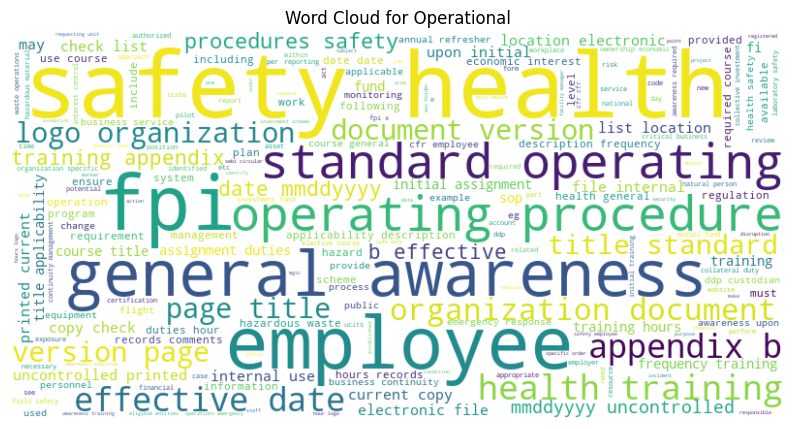

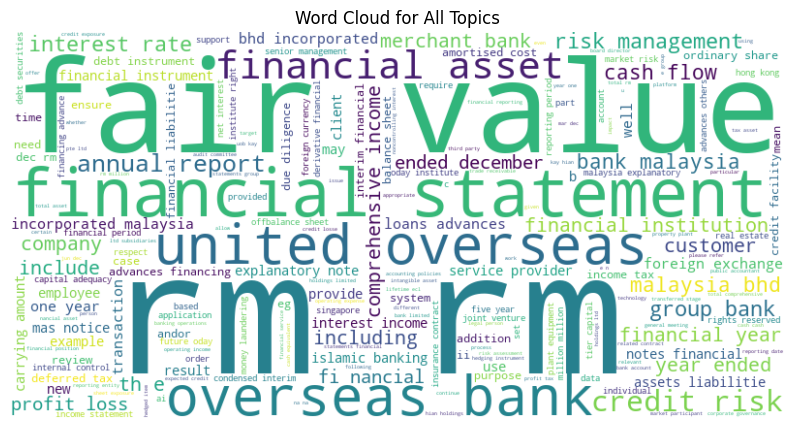

In [23]:

def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Plot word cloud for each topic
for topic, text in combined_texts.items():
    plot_wordcloud(text, title=f"Word Cloud for {topic}")

# Combine all texts into a single string
all_texts = " ".join(combined_texts.values())

# Plot word cloud for all combined texts
plot_wordcloud(all_texts, title="Word Cloud for All Topics")

## **Generate Document-length distribution for each topic**

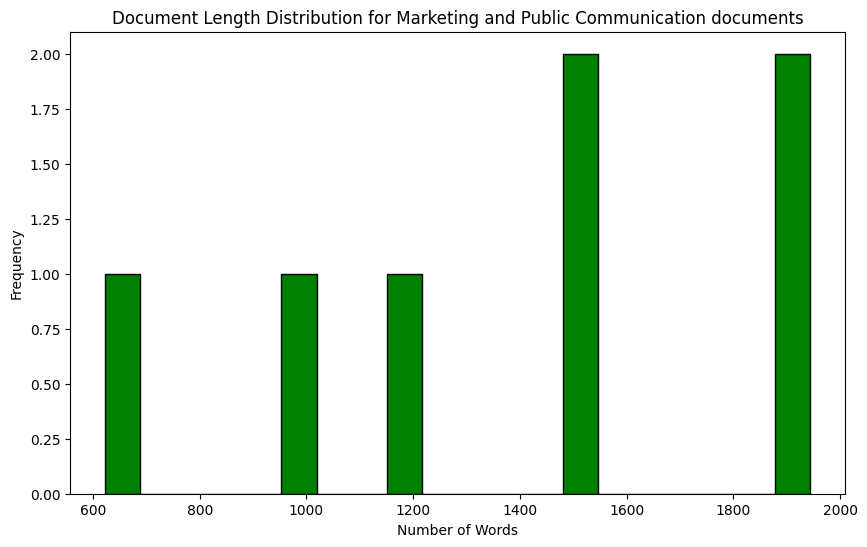

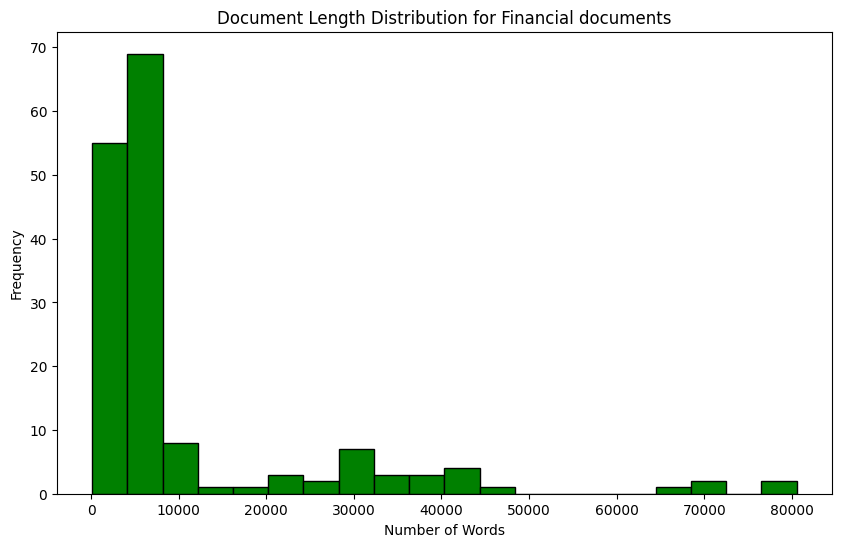

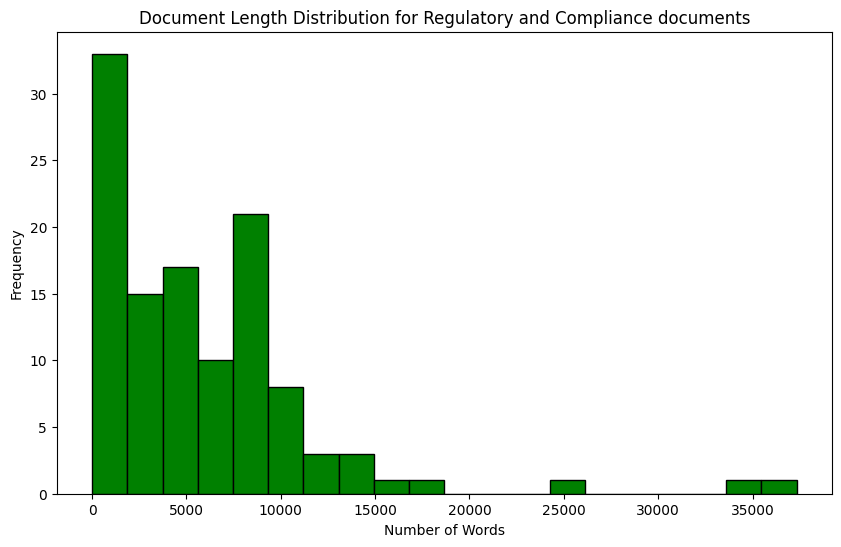

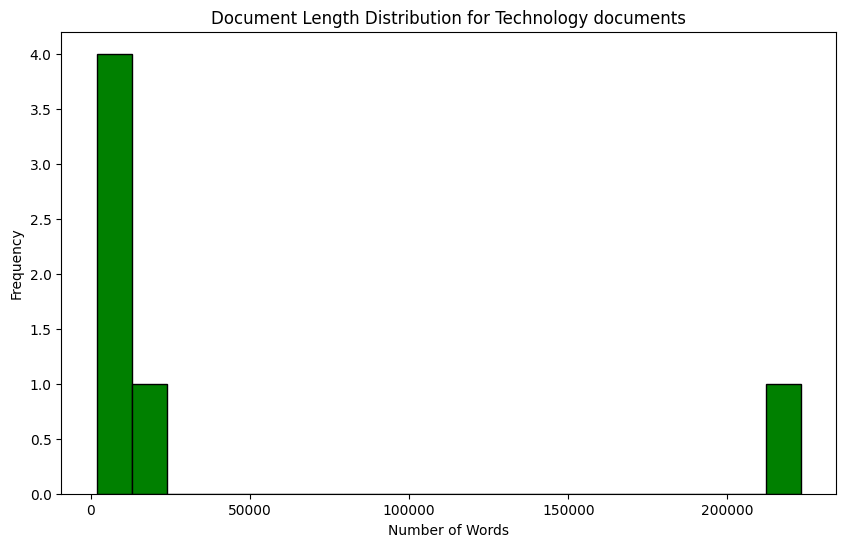

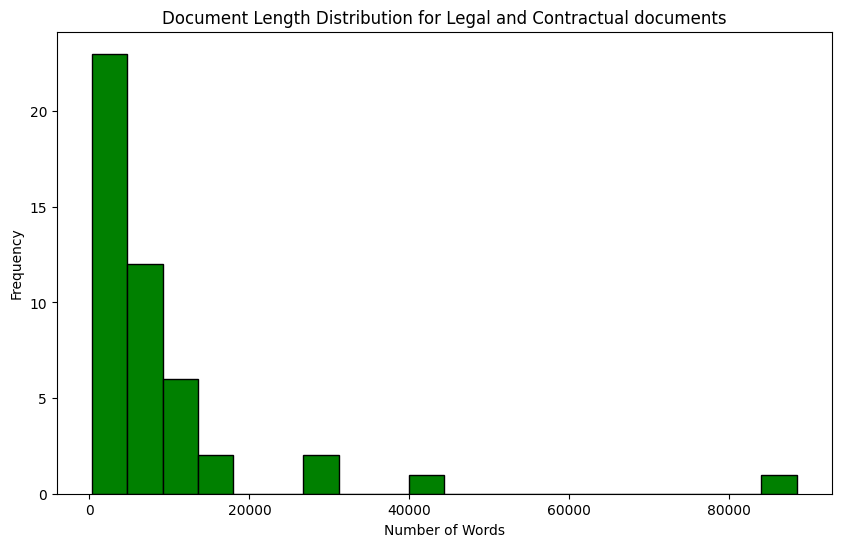

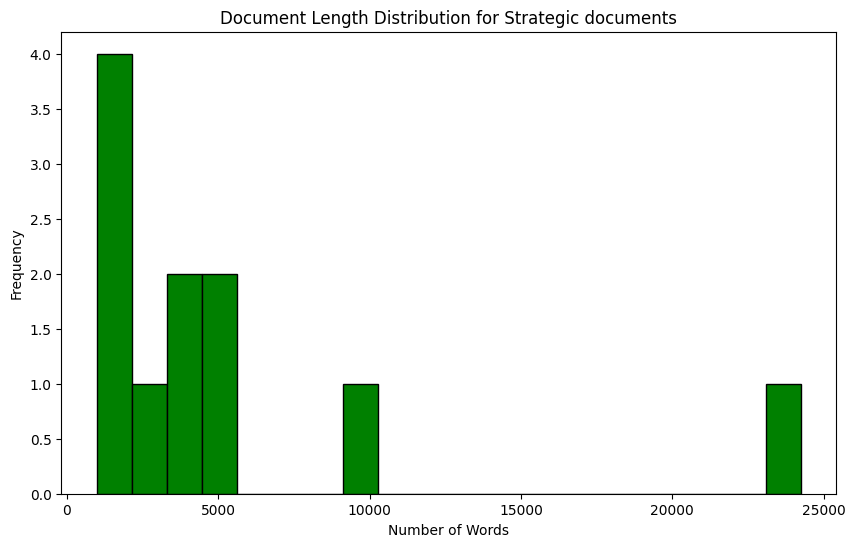

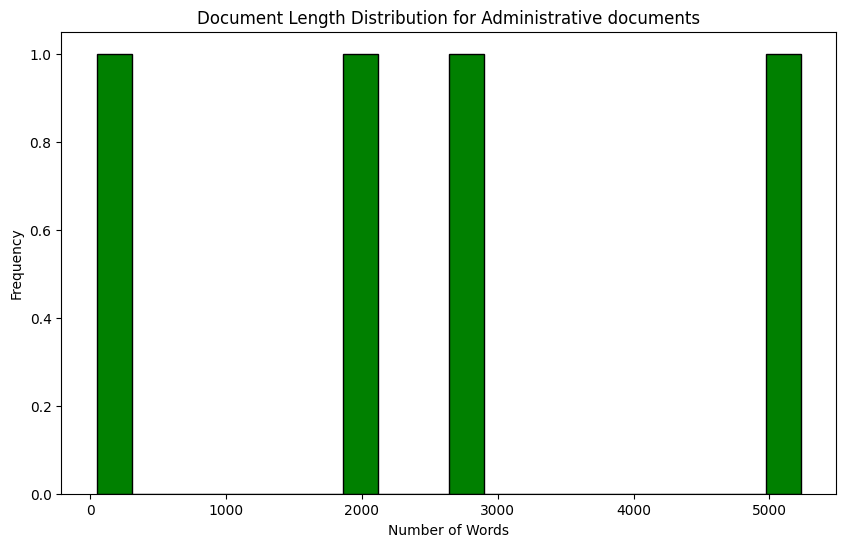

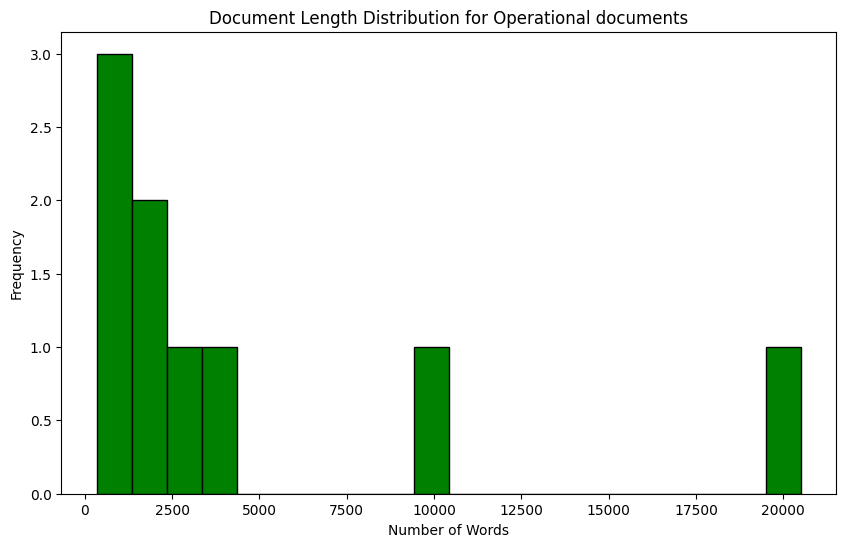

In [24]:
def document_length_distribution(topic_texts, topic_name):
    document_lengths = [len(doc.split()) for doc in topic_texts[topic_name]]
    plt.figure(figsize=(10, 6))
    plt.hist(document_lengths, bins=20, color='green', edgecolor='black')
    plt.title(f'Document Length Distribution for {topic_name} documents')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.show()

for topic in data.keys():
    document_length_distribution(data, topic)


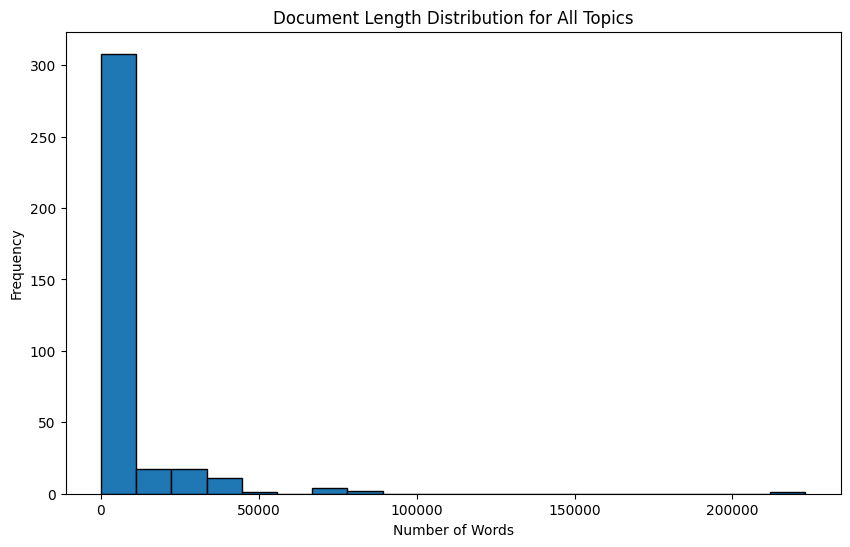

In [25]:
# Combine document lengths for all topics
all_document_lengths = [len(doc.split()) for docs in data.values() for doc in docs]

# Plot document length distribution for all documents
plt.figure(figsize=(10, 6))
plt.hist(all_document_lengths, bins=20, edgecolor='black')
plt.title('Document Length Distribution for All Topics')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

## **Unique Words Counts**

In [26]:
def unique_word_count(text):
    words = text.split()
    unique_words = len(set(words))
    print(f"Number of unique words: {unique_words}")

for topic, text in combined_texts.items():
    print(f"Topic: {topic}")
    unique_word_count(text)


Topic: Marketing and Public Communication
Number of unique words: 2708
Topic: Financial
Number of unique words: 22700
Topic: Regulatory and Compliance
Number of unique words: 17106
Topic: Technology
Number of unique words: 29024
Topic: Legal and Contractual
Number of unique words: 13406
Topic: Strategic
Number of unique words: 9412
Topic: Administrative
Number of unique words: 2794
Topic: Operational
Number of unique words: 5595


# **Topic Similarity**

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Combine all topic texts into a list
topic_names = list(combined_texts.keys())
topic_texts = list(combined_texts.values())

# Convert topics to TF-IDF vectors
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(topic_texts)


In [28]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Compute cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix)

# Create a DataFrame for better visualization
cosine_sim_df = pd.DataFrame(cosine_sim, index=topic_names, columns=topic_names)
print(cosine_sim_df)


                                    Marketing and Public Communication  \
Marketing and Public Communication                            1.000000   
Financial                                                     0.176763   
Regulatory and Compliance                                     0.234129   
Technology                                                    0.433110   
Legal and Contractual                                         0.171135   
Strategic                                                     0.476260   
Administrative                                                0.233831   
Operational                                                   0.117111   

                                    Financial  Regulatory and Compliance  \
Marketing and Public Communication   0.176763                   0.234129   
Financial                            1.000000                   0.578318   
Regulatory and Compliance            0.578318                   1.000000   
Technology                   

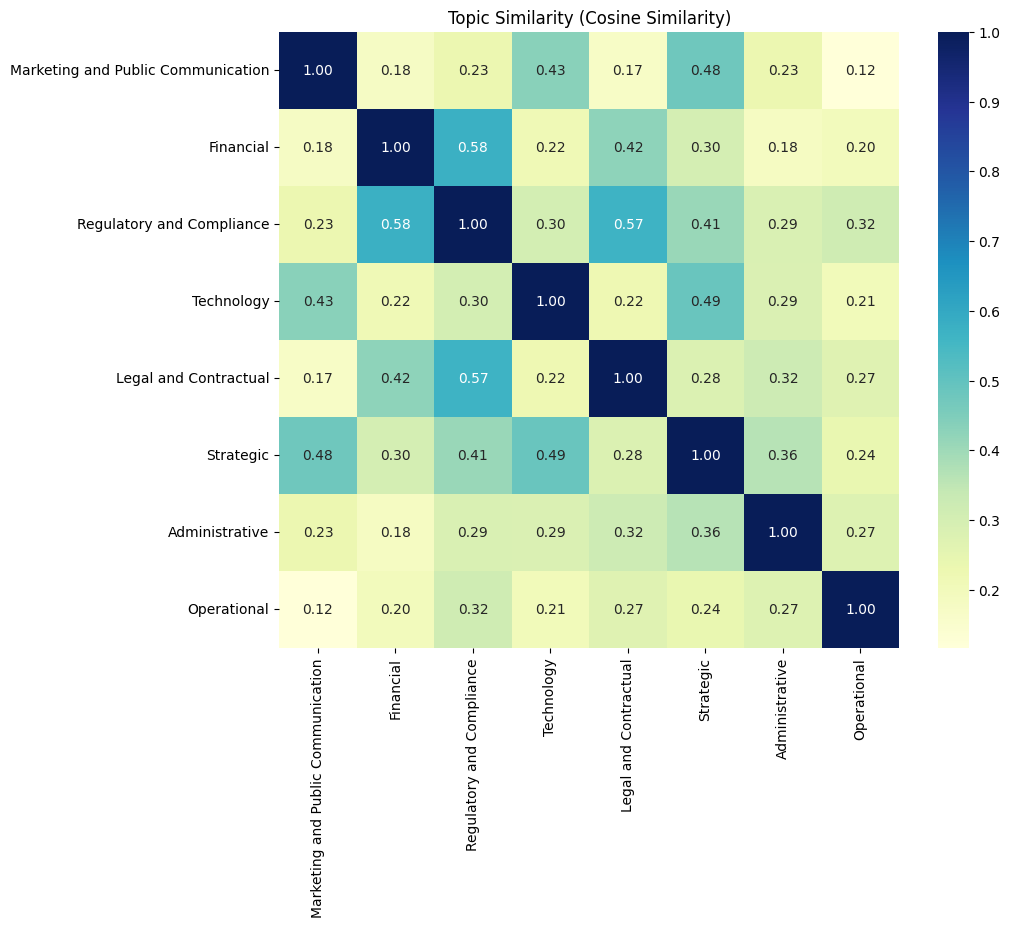

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_df, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Topic Similarity (Cosine Similarity)")
plt.show()


## Token Analysis 

Token indices sequence length is longer than the specified maximum sequence length for this model (1310 > 512). Running this sequence through the model will result in indexing errors


Analyzing token lengths for topic: Marketing and Public Communication


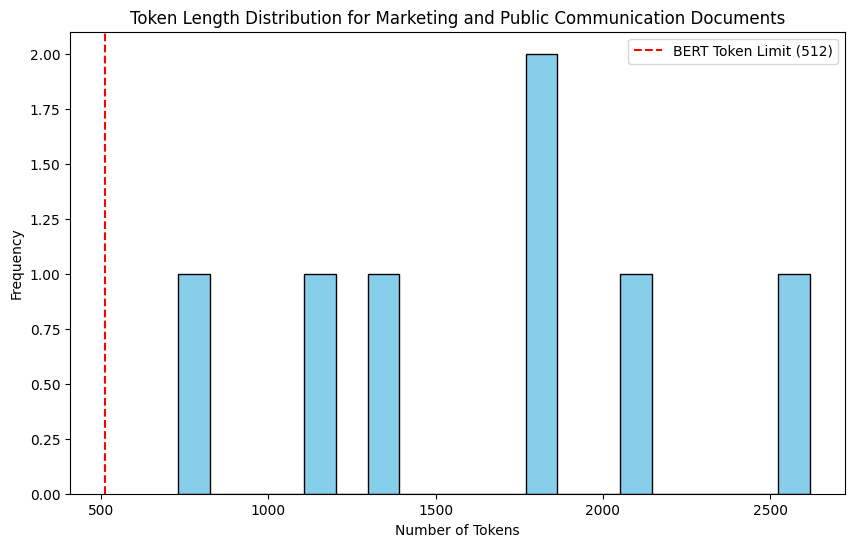

Analyzing token lengths for topic: Financial


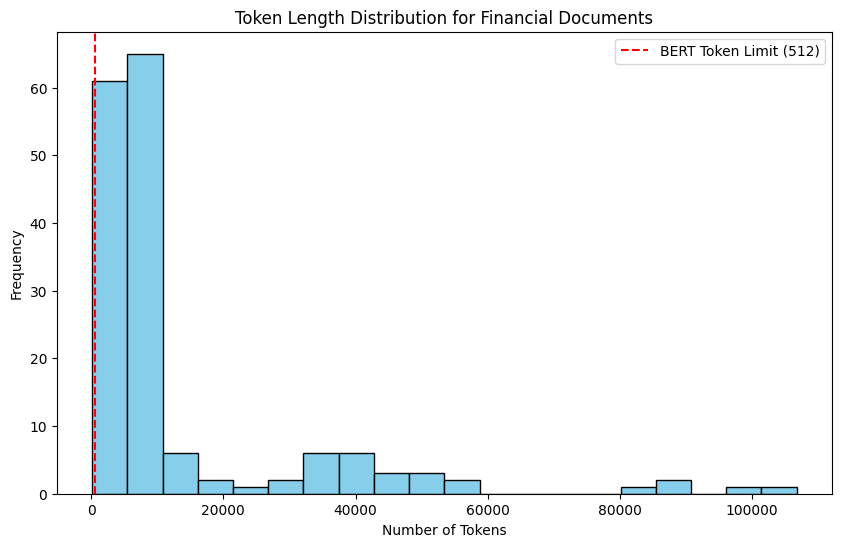

Analyzing token lengths for topic: Regulatory and Compliance


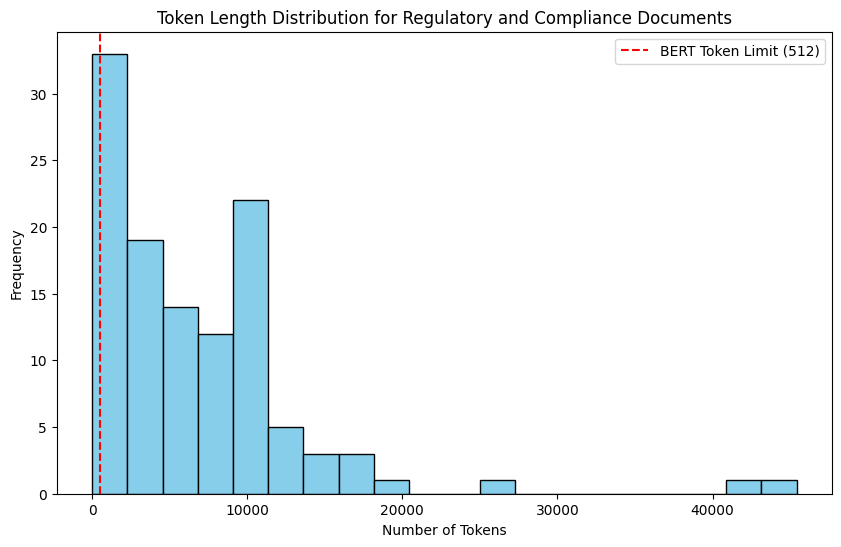

Analyzing token lengths for topic: Technology


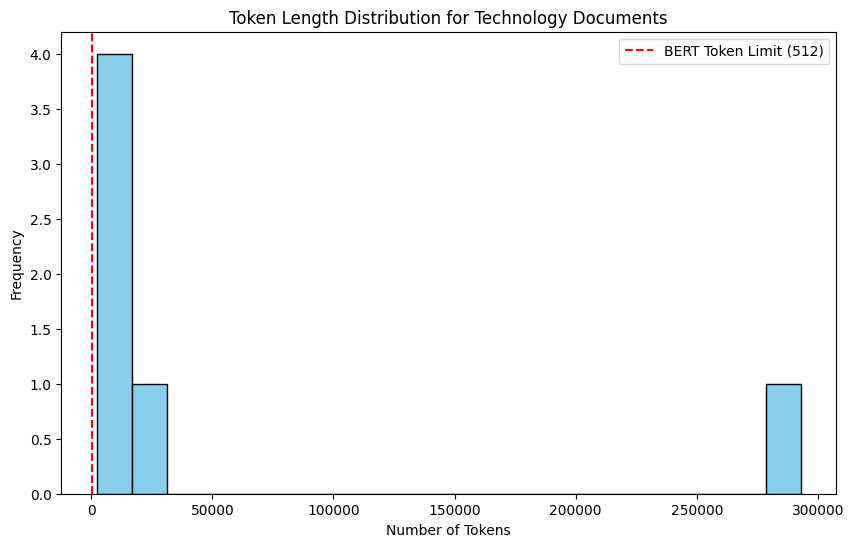

Analyzing token lengths for topic: Legal and Contractual


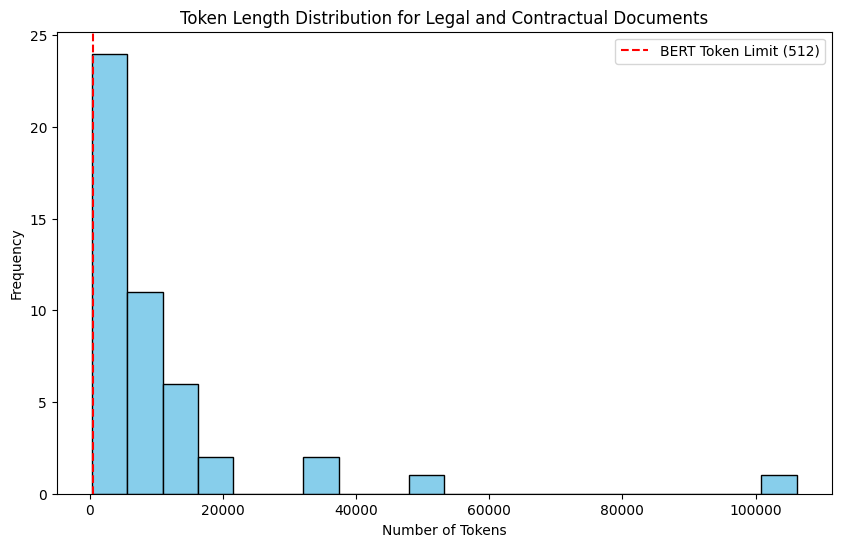

Analyzing token lengths for topic: Strategic


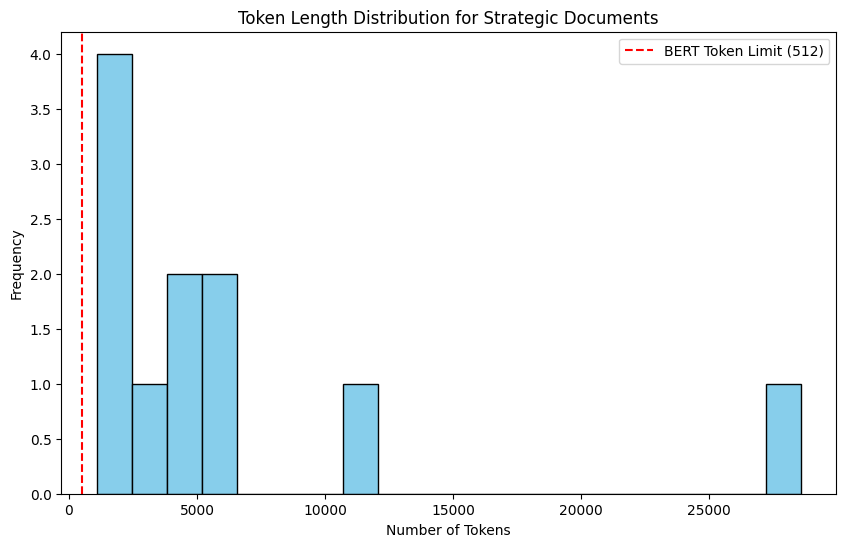

Analyzing token lengths for topic: Administrative


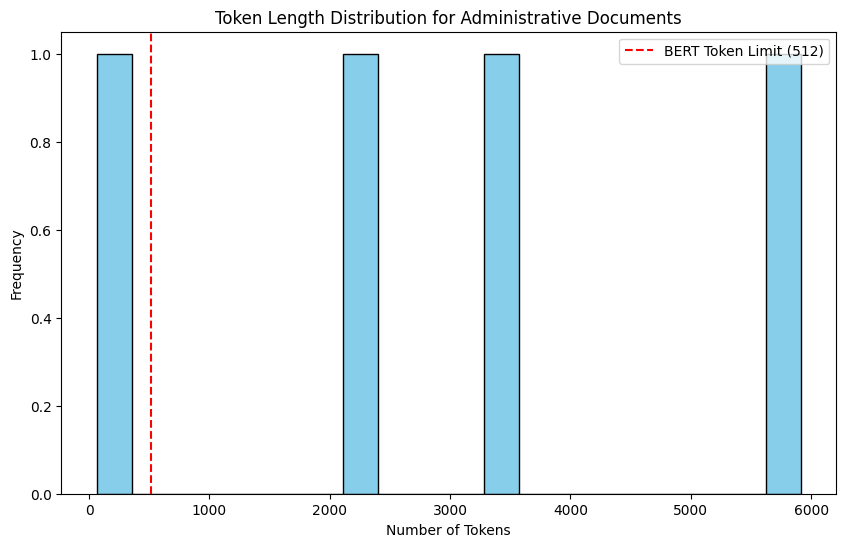

Analyzing token lengths for topic: Operational


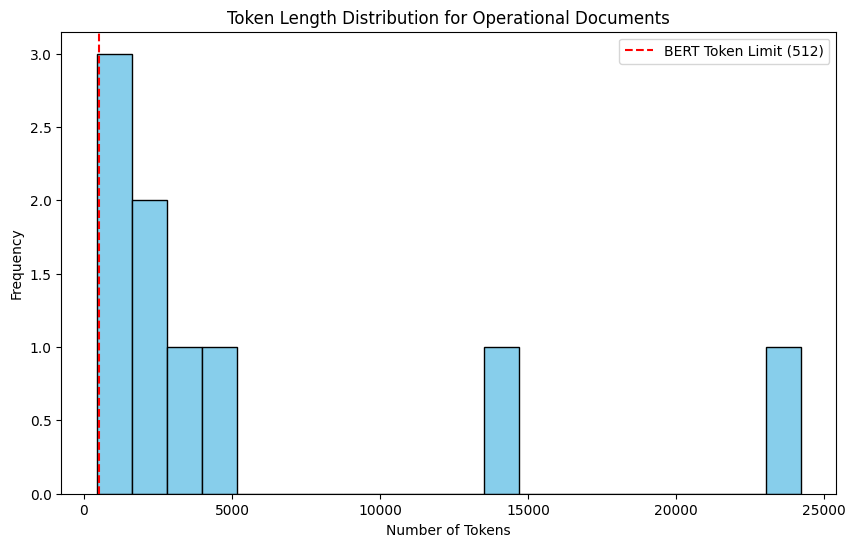

In [30]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

# Initialize tokenizer for tokenization analysis
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")  # Replace with your model's tokenizer

# Function to calculate token lengths for documents
def token_length_distribution(texts, topic_name):
    token_lengths = [len(tokenizer.encode(doc, truncation=False)) for doc in texts]
    plt.figure(figsize=(10, 6))
    plt.hist(token_lengths, bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Token Length Distribution for {topic_name} Documents')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Frequency')
    plt.axvline(x=512, color='red', linestyle='--', label='BERT Token Limit (512)')
    plt.legend()
    plt.show()
    return token_lengths

# Analyze token lengths for each topic
token_lengths_per_topic = {}
for topic, texts in data.items():
    print(f"Analyzing token lengths for topic: {topic}")
    token_lengths = token_length_distribution(texts, topic)
    token_lengths_per_topic[topic] = token_lengths

Token indices sequence length is longer than the specified maximum sequence length for this model (1310 > 512). Running this sequence through the model will result in indexing errors


Analyzing token lengths for topic: Marketing and Public Communication


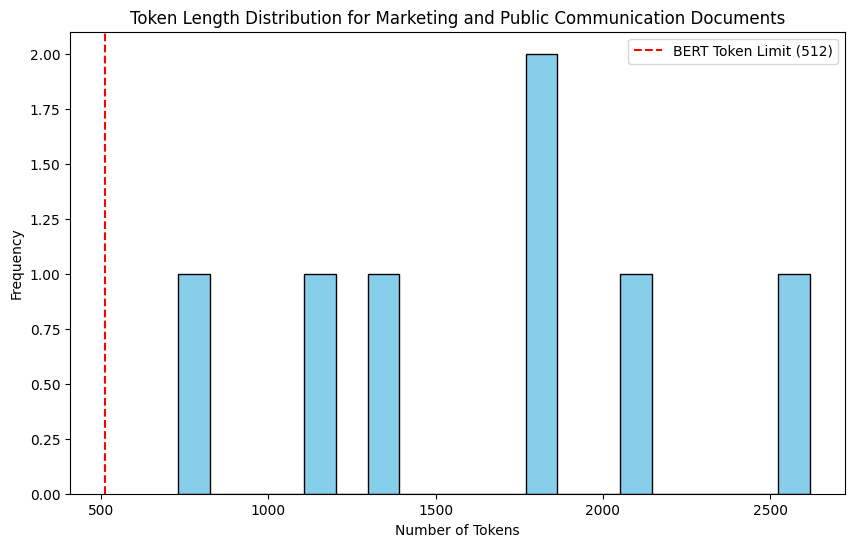

Analyzing token lengths for topic: Financial


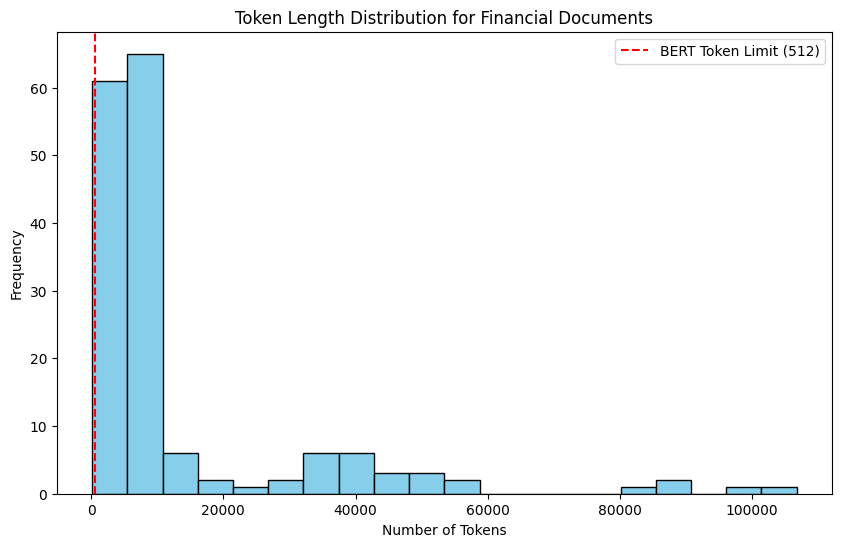

Analyzing token lengths for topic: Regulatory and Compliance


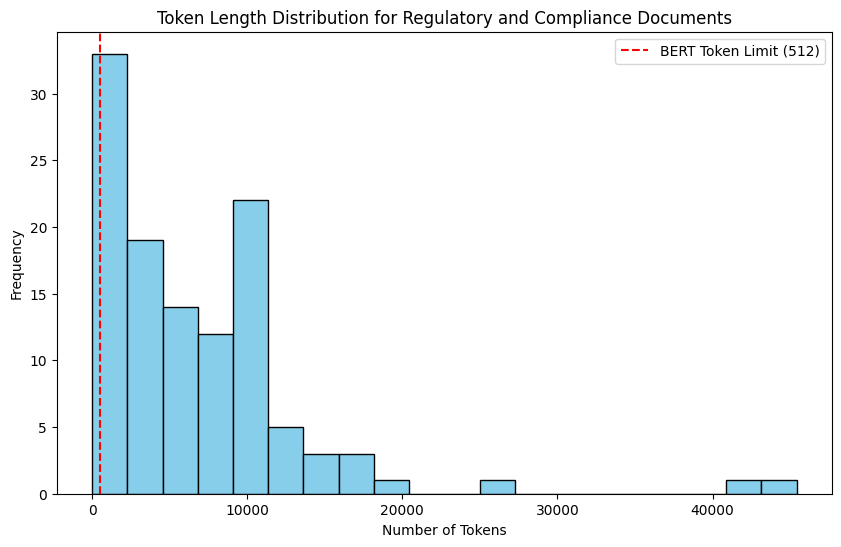

Analyzing token lengths for topic: Technology


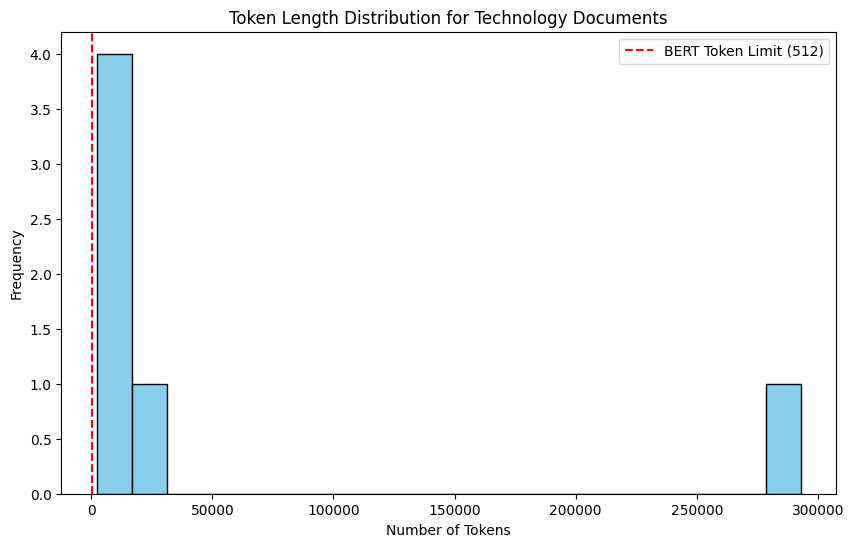

Analyzing token lengths for topic: Legal and Contractual


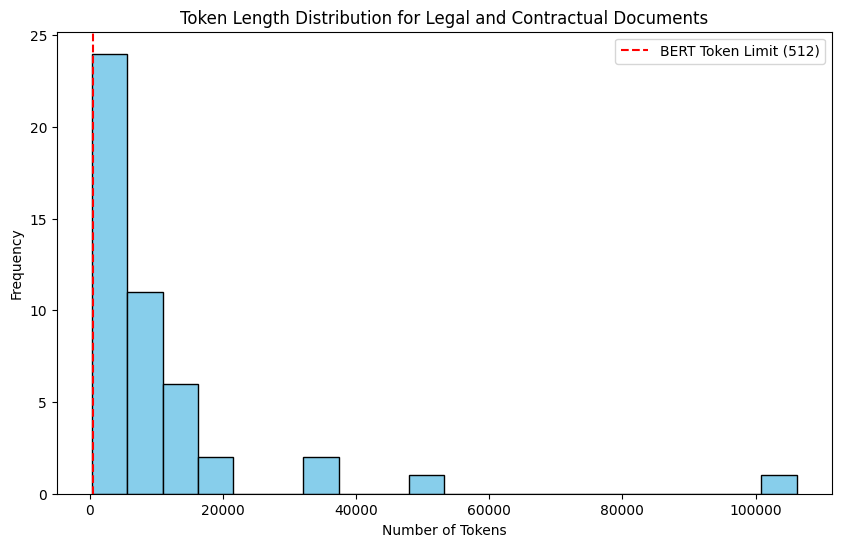

Analyzing token lengths for topic: Strategic


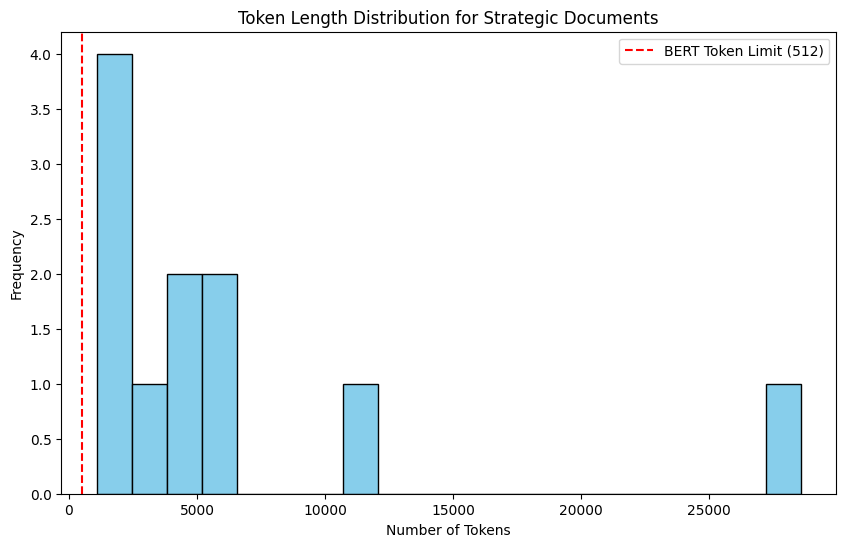

Analyzing token lengths for topic: Administrative


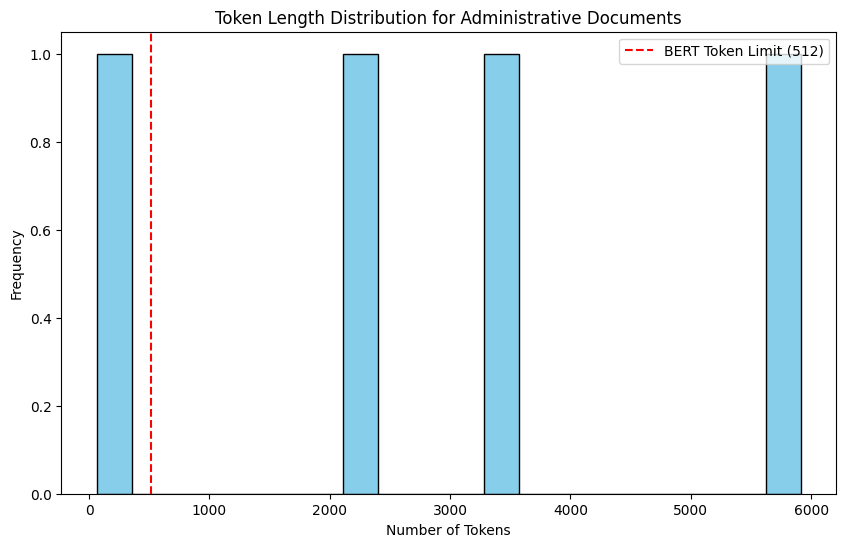

Analyzing token lengths for topic: Operational


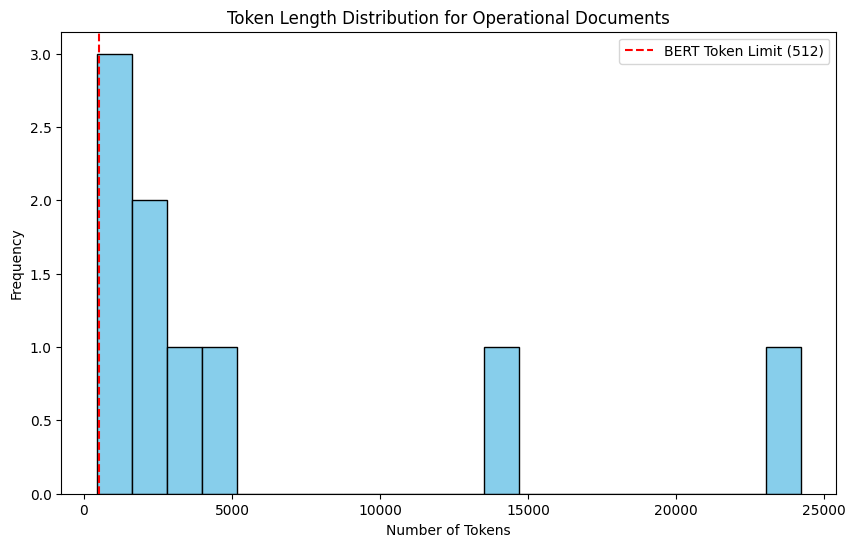

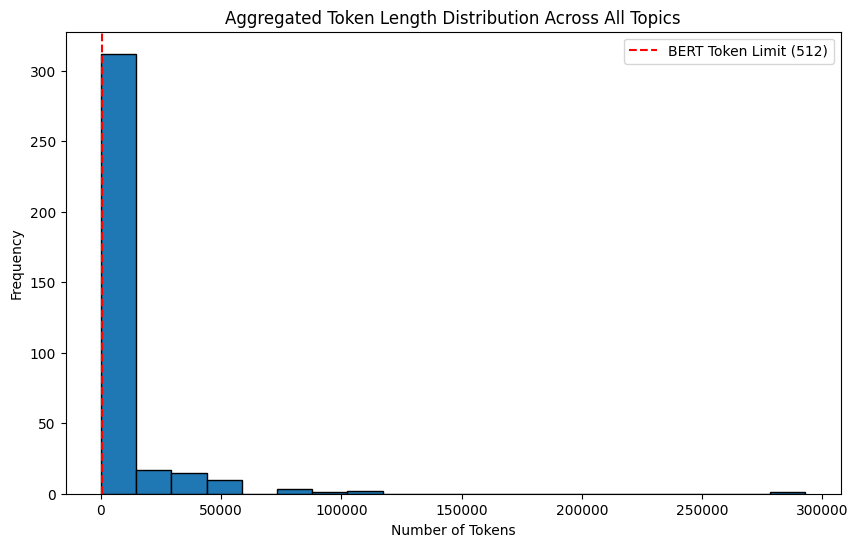

In [31]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

# Initialize tokenizer for tokenization analysis
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")  # Replace with your model's tokenizer

# Function to calculate token lengths for documents
def token_length_distribution(texts, topic_name):
    token_lengths = [len(tokenizer.encode(doc, truncation=False)) for doc in texts]
    plt.figure(figsize=(10, 6))
    plt.hist(token_lengths, bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Token Length Distribution for {topic_name} Documents')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Frequency')
    plt.axvline(x=512, color='red', linestyle='--', label='BERT Token Limit (512)')
    plt.legend()
    plt.show()
    return token_lengths

# Analyze token lengths for each topic
token_lengths_per_topic = {}
all_token_lengths = []  # To store token lengths across all topics

for topic, texts in data.items():
    print(f"Analyzing token lengths for topic: {topic}")
    token_lengths = token_length_distribution(texts, topic)
    token_lengths_per_topic[topic] = token_lengths
    all_token_lengths.extend(token_lengths)  # Aggregate token lengths

# Plot aggregated token length distribution across all topics
plt.figure(figsize=(10, 6))
plt.hist(all_token_lengths, bins=20, edgecolor='black')
plt.title('Aggregated Token Length Distribution Across All Topics')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.axvline(x=512, color='red', linestyle='--', label='BERT Token Limit (512)')
plt.legend()
plt.show()


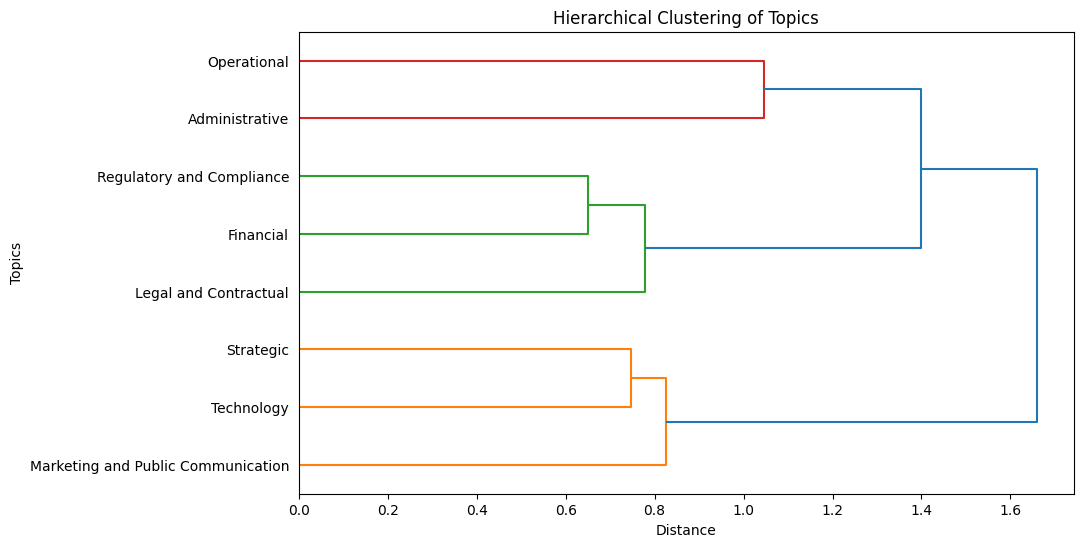

In [32]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

# Function to perform clustering based on cosine similarity
def plot_topic_clustering(tfidf_matrix, topic_names):
    cosine_sim = cosine_similarity(tfidf_matrix)
    linkage_matrix = linkage(1 - cosine_sim, method='ward')  # Use Ward's method for hierarchical clustering

    # Plot dendrogram
    plt.figure(figsize=(10, 6))
    dendrogram(linkage_matrix, labels=topic_names, orientation='right', leaf_font_size=10)
    plt.title('Hierarchical Clustering of Topics')
    plt.xlabel('Distance')
    plt.ylabel('Topics')
    plt.show()

    return cosine_sim

# Generate TF-IDF vectors for all topics
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(combined_texts.values())
topic_names = list(combined_texts.keys())

# Plot clustering
cosine_similarity_matrix = plot_topic_clustering(tfidf_matrix, topic_names)


# Identify Key Entities or Rare Words

In [34]:
import spacy

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 2_000_000  # Increase limit (but safer to chunk text)

# Function to extract named entities in chunks
def extract_named_entities(text, chunk_size=500_000):
    entities = []
    text_length = len(text)
    
    for i in range(0, text_length, chunk_size):
        chunk = text[i:i + chunk_size]
        doc = nlp(chunk)
        entities.extend([ent.text for ent in doc.ents])
    
    return entities

# Apply to each topic
entity_results = {topic: extract_named_entities(text) for topic, text in combined_texts.items()}

# Display unique named entities per topic
for topic, entities in entity_results.items():
    print(f"\nTopic: {topic}")
    print(set(entities[:20]))  # Display only first 20 for readability



Topic: Marketing and Public Communication
{'one', 'second year', 'liampoti moritz hagenm ller', 'four', 'year', 'europe', 'approximately half', 'last year', 'annually', 'urs rahne', 'million', 'september'}

Topic: Financial
{'ccr internal models method', 'last quarter quarter last year', 'recognition', 'ccr', 'mar', 'annex', 'year year', 'ccp', 'jun mar', 'march united overseas bank limited', 'ris', 'ris kbas ed capital ratios percentage rwa cet', 'sft counterparty', 'quarter quarter', 'mar dec', 'mar dec mar'}

Topic: Regulatory and Compliance
{'singapore', 'annual', 'first', 'secondhalf fourth quarter', 'january', 'full year', 'year ending june', 'june', 'days', 'institute singapore', 'september'}

Topic: Technology
{'singapore', 'three', 'willis lim dr luke ho', 'disclaims warranty', 'ho w fsisac advances', 'manipulat ed', 'tomorrow', 'gpt', 'jaslynn tan', 'chin', 'yond', 'w ho'}

Topic: Legal and Contractual
{'one', 'singapore', 'corporation bank amalgamates corporation bank', 'cu

In [38]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Function to extract rare words using TF-IDF
def extract_rare_words(corpus_dict):
    vectorizer = TfidfVectorizer(stop_words="english", max_features=10000)
    tfidf_matrix = vectorizer.fit_transform(corpus_dict.values())
    feature_names = vectorizer.get_feature_names_out()

    # Convert TF-IDF matrix to DataFrame
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=corpus_dict.keys(), columns=feature_names)

    # Find rare words: words with high TF-IDF in one category but low in others
    rare_words_per_category = {}
    for topic in tfidf_df.index:
        rare_words = tfidf_df.loc[topic].nlargest(10)  # Get top 10 rare words per category
        rare_words_per_category[topic] = rare_words.index.tolist()

    return rare_words_per_category

# Run rare word analysis
rare_words = extract_rare_words(combined_texts)

# Print rare words per category
print("\n🔹 Rare Words Per Topic:")
for topic, words in rare_words.items():
    print(f"\n📌 {topic}: {words}")



🔹 Rare Words Per Topic:

📌 Marketing and Public Communication: ['loyalty', 'personalization', 'ai', 'genai', 'personalized', 'marketing', 'content', 'companies', 'data', 'customers']

📌 Financial: ['financial', 'rm', 'group', 'bank', 'risk', 'assets', 'income', 'total', 'credit', 'year']

📌 Regulatory and Compliance: ['bank', 'risk', 'financial', 'audit', 'singapore', 'mas', 'customer', 'information', 'merchant', 'management']

📌 Technology: ['ai', 'oday', 'future', 'new', 'institute', 'data', 'rights', 'reserved', 'tech', 'technology']

📌 Legal and Contractual: ['shall', 'uobkh', 'client', 'company', 'hedge', 'dh', 'agreement', 'hedging', 'hedged', 'value']

📌 Strategic: ['business', 'digital', 'customer', 'cwm', 'companies', 'new', 'strategy', 'management', 'company', 'value']

📌 Administrative: ['employee', 'employees', 'work', 'company', 'new', 'neglix', 'buddy', 'people', 'day', 'use']

📌 Operational: ['training', 'fpi', 'safety', 'cfr', 'health', 'date', 'mmddyyyy', 'course', 'a

### Using NER to extract top named entities

In [35]:
import spacy
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

# Function to extract named entities from text
def extract_named_entities(text):
    doc = nlp(text[:1_000_000])  # Process only first 1M chars to avoid memory errors
    return [ent.text.lower() for ent in doc.ents]

# Apply NER to each category
entity_counts = {}
for topic, text in combined_texts.items():
    entities = extract_named_entities(text)
    entity_counts[topic] = Counter(entities).most_common(10)  # Show top 10 entities

# Display entity results
print("\nTop Named Entities Per Topic:")
for topic, entities in entity_counts.items():
    print(f"\n{topic}: {entities}")

# TF-IDF Analysis
vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(combined_texts.values())
feature_names = vectorizer.get_feature_names_out()

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=combined_texts.keys(), columns=feature_names)

# Show top words for each topic
print("\nTop TF-IDF Words Per Category:")
for topic in tfidf_df.index:
    print(f"\n{topic}: {tfidf_df.loc[topic].nlargest(10)}")



Top Named Entities Per Topic:

Marketing and Public Communication: [('boston consulting', 26), ('one', 13), ('three', 11), ('four', 10), ('europe', 9), ('european', 9), ('today', 7), ('half', 6), ('last year', 5), ('million', 5)]

Financial: [('singapore', 1041), ('one', 126), ('two', 81), ('ccr', 60), ('annual', 60), ('million', 57), ('years', 50), ('three', 46), ('four', 45), ('december', 41)]

Regulatory and Compliance: [('singapore', 247), ('year', 93), ('first', 82), ('annual', 70), ('one', 69), ('november', 62), ('june', 55), ('september', 54), ('two', 54), ('second', 51)]

Technology: [('first', 124), ('one', 123), ('china', 95), ('singapore', 92), ('two', 66), ('million', 65), ('february', 52), ('al', 46), ('december', 43), ('july', 42)]

Legal and Contractual: [('singapore', 231), ('one', 130), ('two', 62), ('first', 60), ('third', 49), ('august', 46), ('indonesia', 44), ('december', 34), ('us', 30), ('malaysia', 28)]

Strategic: [('one', 115), ('shenzhen', 88), ('india', 68)

**Analysis**:
From the above, we can see that many of the top words are numbers, or months that do not give us much insight. Hence, in the cell below, we shall remove those words.

In [43]:
import spacy
import pandas as pd

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

# Define words to exclude (numbers, months, general countries)
excluded_words = {
    "one", "two", "three", "four", "five", "million", "billion",
    "january", "february", "march", "april", "may", "june",
    "july", "august", "september", "october", "november", "december"
}

excluded_countries = {
    "singapore", "china", "us", "america", "united states", "europe", 
    "india", "japan", "uk", "british", "french", "german"
}

# Function to extract named entities in chunks
def extract_filtered_entities(text, chunk_size=500_000):
    entities = []
    text_length = len(text)
    
    for i in range(0, text_length, chunk_size):
        chunk = text[i:i + chunk_size]
        doc = nlp(chunk)
        filtered = [
            ent.text for ent in doc.ents 
            if ent.text.lower() not in excluded_words and ent.text.lower() not in excluded_countries
        ]
        entities.extend(filtered)
    
    return list(set(entities))  # Remove duplicates

# Apply filtering to dataset
filtered_entities_per_topic = {topic: extract_filtered_entities(text) for topic, text in combined_texts.items()}

# Convert to DataFrame
ner_df = pd.DataFrame([(topic, entity) for topic, entities in filtered_entities_per_topic.items() for entity in entities], 
                      columns=["Topic", "Named Entity"])

# Save to CSV
ner_csv_path = "filtered_named_entities.csv"
ner_df.to_csv(ner_csv_path, index=False)

# Print completion message
print(f"✅ NER processing completed. Saved to {ner_csv_path}")


✅ NER processing completed. Saved to filtered_named_entities.csv


In [44]:
import spacy
import pandas as pd
from collections import Counter

# Load SpaCy model (disable unused components to save memory)
nlp = spacy.load("en_core_web_sm", disable=["parser", "tagger"])

# Define words to exclude (numbers, months, general countries)
excluded_words = {
    "one", "two", "three", "four", "five", "million", "billion",
    "january", "february", "march", "april", "may", "june",
    "july", "august", "september", "october", "november", "december"
}

excluded_countries = {
    "singapore", "china", "us", "america", "united states", "europe", 
    "india", "japan", "uk", "british", "french", "german"
}

# Function to extract named entities in chunks
def extract_filtered_entities_with_counts(text, chunk_size=25_000):
    entities = []
    text_length = len(text)

    for i in range(0, text_length, chunk_size):
        chunk = text[i:i + chunk_size]
        doc = nlp(chunk)
        filtered = [
            ent.text.lower() for ent in doc.ents 
            if ent.text.lower() not in excluded_words and ent.text.lower() not in excluded_countries
        ]
        entities.extend(filtered)

    return Counter(entities).most_common(10)  # Get top 10 entities


# Apply filtering and counting to dataset
entity_counts = {topic: extract_filtered_entities_with_counts(text) for topic, text in combined_texts.items()}

# Print top named entities per topic
print("\nTop Named Entities Per Topic:")
for topic, entities in entity_counts.items():
    print(f"\n{topic}: {entities}")


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)



Top Named Entities Per Topic:

Marketing and Public Communication: [('boston consulting', 26), ('european', 9), ('today', 7), ('half', 6), ('last year', 5), ('departments treasury labor health human services', 4), ('google', 4), ('mark abraham', 4), ('hundreds', 4), ('boston consulting group', 4)]

Financial: [('malaysia', 6630), ('annual', 4633), ('year', 2107), ('year ended december', 1796), ('k united overseas bank', 1757), ('islamic', 1709), ('rm rm', 1325), ('united overseas bank', 1054), ('rm', 902), ('malaysia bhd', 882)]

Regulatory and Compliance: [('third', 582), ('first', 302), ('annual', 265), ('years', 227), ('uobam', 217), ('year', 202), ('ccp', 194), ('monthly', 167), ('second', 162), ('eurex', 134)]

Technology: [('first', 294), ('year', 231), ('quantum', 159), ('future oday institute rights reserved', 121), ('al', 99), ('today', 79), ('future oday institute rights', 64), ('microsoft', 62), ('european', 56), ('nasa', 52)]

Legal and Contractual: [('third', 498), ('firs

### Improved NER

In [4]:
import spacy
import re

# Load SpaCy model (Consider using 'en_core_web_trf' for better performance)
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 2_000_000  # Adjust limit for large text

# Define stop words to exclude
excluded_words = {
    "one", "two", "three", "four", "five", "million", "billion",
    "january", "february", "march", "april", "may", "june",
    "july", "august", "september", "october", "november", "december",
    "year", "years", "month", "months", "day", "days", "time"
}

excluded_countries = {
    "singapore", "china", "us", "america", "united states", "europe", 
    "india", "japan", "uk", "british", "french", "german"
}

# Function to extract named entities in chunks
def extract_filtered_entities(text, chunk_size=500_000):
    entities = []
    text_length = len(text)
    
    for i in range(0, text_length, chunk_size):
        chunk = text[i:i + chunk_size]
        doc = nlp(chunk)
        
        # Filter out irrelevant entities
        filtered = [
            ent.text.strip() for ent in doc.ents
            if ent.text.lower() not in excluded_words 
            and ent.text.lower() not in excluded_countries
            and ent.label_ not in {"DATE", "TIME", "ORDINAL", "PERSON"}  # Remove names & dates
        ]

        # Clean up tokenization errors
        cleaned_entities = [re.sub(r"\s+", " ", ent) for ent in filtered]
        
        entities.extend(cleaned_entities)

    return list(set(entities))  # Remove duplicates

# Apply filtering to dataset
filtered_entities_per_topic = {topic: extract_filtered_entities(text) for topic, text in combined_texts.items()}

# Display cleaned named entities per topic
for topic, entities in filtered_entities_per_topic.items():
    print(f"\n🔹 Topic: {topic}")
    print(set(entities[:20]))  # Display only first 20 for readability



🔹 Topic: Marketing and Public Communication
{'florian kogler', 'london', 'new jersey office', 'chicago', 'boston', 'atlanta', 'harvard business review article', 'dallas boston consulting group', 'google', 'woolworth australia sobey canada', 'north america', 'approximately half', 'dozen', 'basis boston consulting group', 'half', 'min boston consulting group', 'delta', 'ten', 'million million', 'brazilian'}

🔹 Topic: Financial
{'v e l p e n', 'kapito', 'macau sar overseas branches', 'oversees bank financial reporting effectiveness', 'grou p', 'waterloo canada directors consortium', 'asean greater bay', 'singapore storey', 'malaysia group risk capital committee rcc', 'chinese', 'board sustainability committee member risk management committee length service', 'building dubai international financial centre po', 'national environment agency board', 'gs legal regulatory', 'twelve', 'greater china business office coverage', 'federal reserve', 'three five', 'pwc holdings ltd take', 'ccp centra

### Most Common Words

In [37]:
from collections import Counter

# Function to count word frequency
def count_word_frequency(text):
    words = text.split()  # Since text is pre-cleaned, just split by space
    return Counter(words).most_common(20)  # Get top 20 most frequent words

# Compute word frequency for each topic
word_freq_per_topic = {}

for topic, text in combined_texts.items():
    word_freq = count_word_frequency(text)
    word_freq_per_topic[topic] = word_freq

# Print high-frequency words per topic
print("\n🔹 Top High-Frequency Words Per Topic:")
for topic, words in word_freq_per_topic.items():
    print(f"\nTopic: {topic}:")
    for word, count in words:
        print(f"{word}: {count}")



🔹 Top High-Frequency Words Per Topic:

Topic: Marketing and Public Communication:
ai: 100
loyalty: 100
marketing: 82
content: 81
companies: 79
data: 78
customers: 76
customer: 75
programs: 71
personalization: 63
genai: 58
creative: 53
use: 52
personalized: 47
boston: 42
consulting: 41
consumers: 41
program: 41
new: 40
leaders: 40

Topic: Financial:
financial: 24755
group: 17917
rm: 17124
bank: 17036
risk: 15228
assets: 14012
income: 12242
total: 11665
credit: 10792
year: 10441
capital: 8689
management: 8504
value: 8344
company: 8321
statements: 8262
december: 8021
malaysia: 8005
net: 7738
cash: 7541
fair: 7246

Topic: Regulatory and Compliance:
bank: 5453
risk: 5234
may: 4625
financial: 4561
audit: 4059
customer: 4023
information: 3832
management: 3405
singapore: 3279
mas: 3221
b: 3156
business: 3145
risks: 2735
merchant: 2613
company: 2602
notice: 2597
transactions: 2458
relevant: 2398
section: 2379
banks: 2147

Topic: Technology:
ai: 2113
new: 1524
future: 1442
data: 1298
institute:

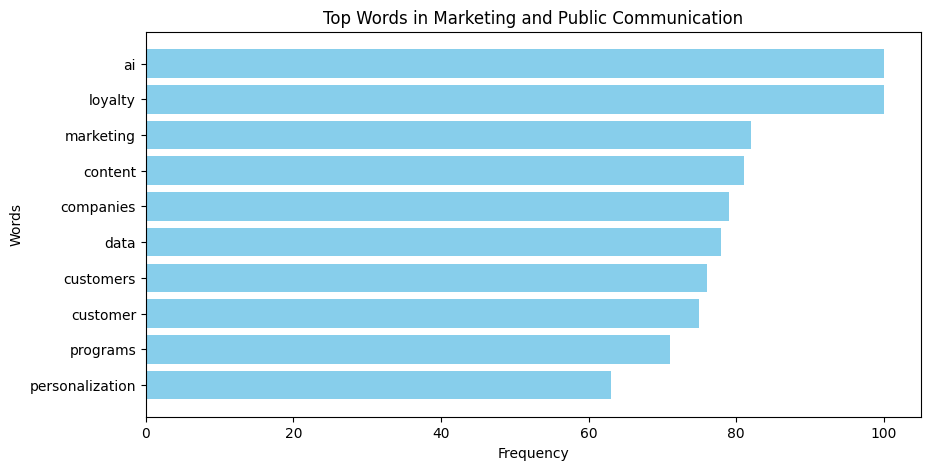

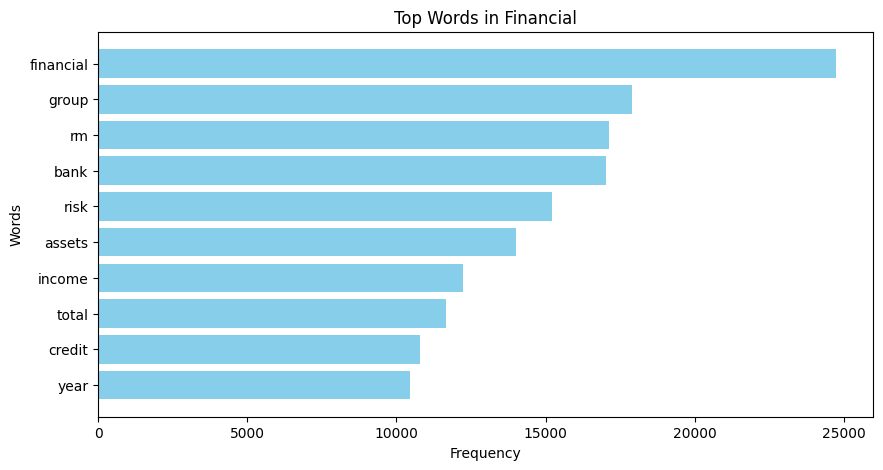

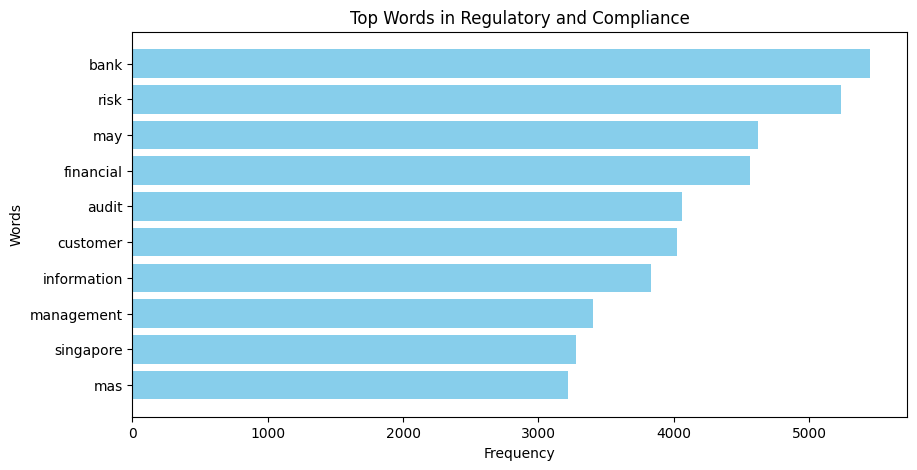

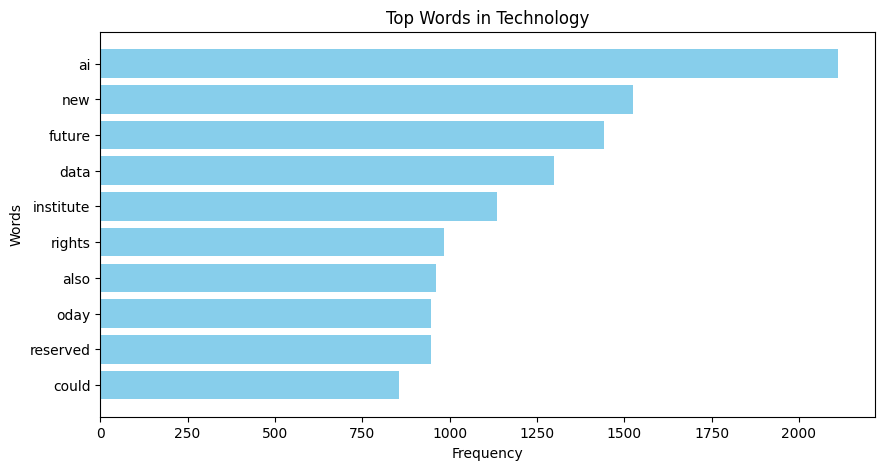

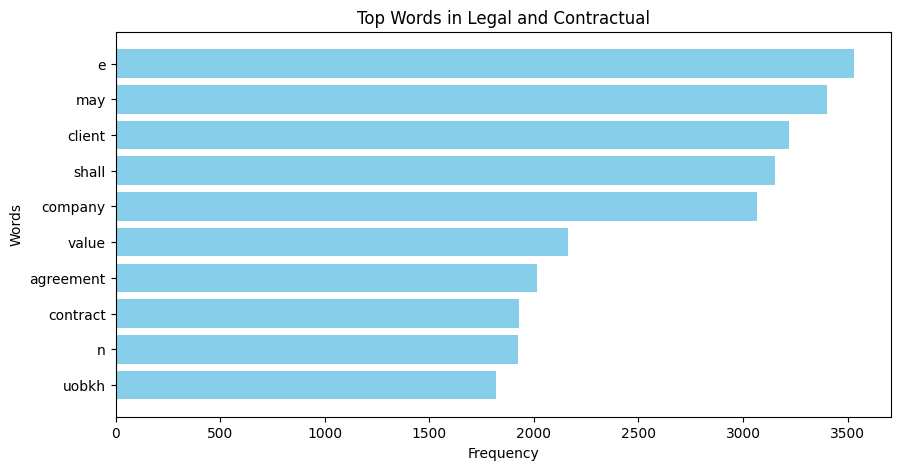

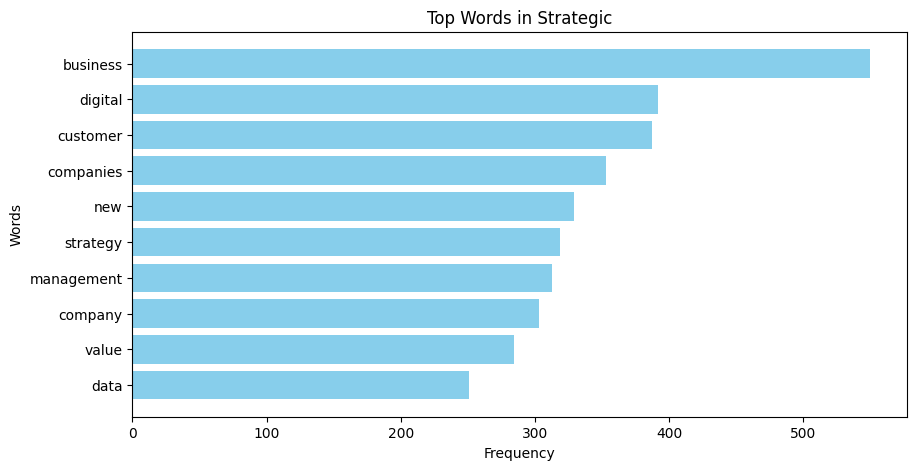

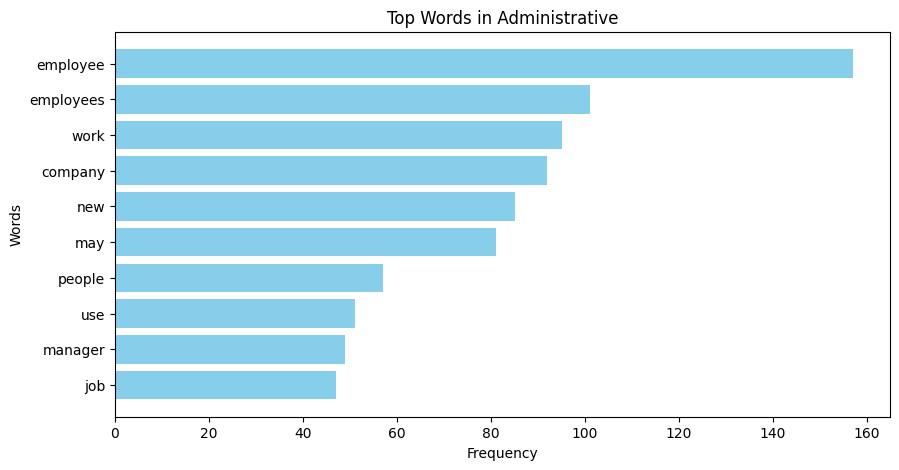

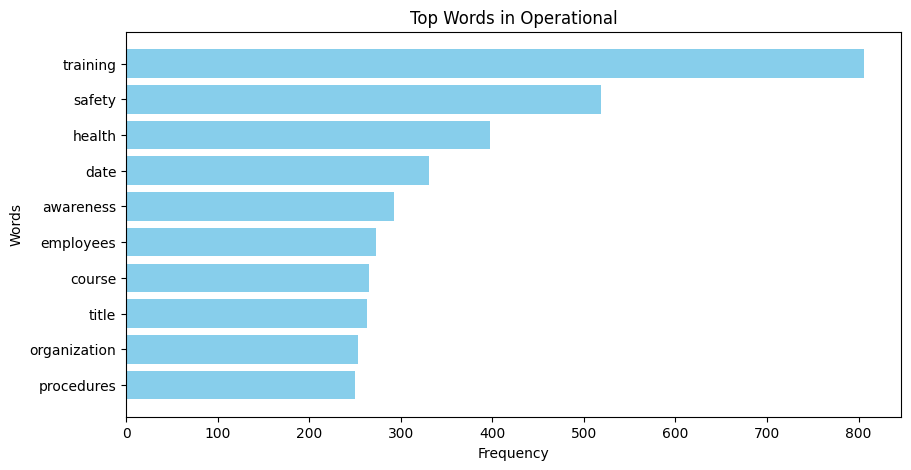

In [40]:
# Generate High-Frequency Words Bar Charts
for topic, words in word_freq_per_topic.items():
    words, counts = zip(*words[:10])  # Get top 10 words
    plt.figure(figsize=(10, 5))
    plt.barh(words, counts, color='skyblue')
    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.title(f"Top Words in {topic}")
    plt.gca().invert_yaxis()
    plt.show()


Topic             Word  Count
0   Marketing and Public Communication               ai    100
1   Marketing and Public Communication          loyalty    100
2   Marketing and Public Communication        marketing     82
3   Marketing and Public Communication          content     81
4   Marketing and Public Communication        companies     79
5   Marketing and Public Communication             data     78
6   Marketing and Public Communication        customers     76
7   Marketing and Public Communication         customer     75
8   Marketing and Public Communication         programs     71
9   Marketing and Public Communication  personalization     63
10  Marketing and Public Communication            genai     58
11  Marketing and Public Communication         creative     53
12  Marketing and Public Communication              use     52
13  Marketing and Public Communication     personalized     47
14  Marketing and Public Communication           boston     42
15  Marketing and Public Communication       consulting     41
16  Marketing and Public Communication        consumers     41
17  Marketing and Public Communication          program     41
18  Marketing and Public Communication              new     40
19  Marketing and Public Communication          leaders     40

Topic       Rare Word
0   Marketing and Public Communication         thrived
1   Marketing and Public Communication         tripled
2   Marketing and Public Communication  bestperforming
3   Marketing and Public Communication       september
4   Marketing and Public Communication         slowing
5   Marketing and Public Communication  wellpublicized
6   Marketing and Public Communication  restructurings
7   Marketing and Public Communication       resilient
8   Marketing and Public Communication       prospects
9   Marketing and Public Communication       confirmed
10  Marketing and Public Communication            amid
11  Marketing and Public Communication        centered
12  Marketing and Public Communication     significant
13  Marketing and Public Communication        annually
14  Marketing and Public Communication       declining
15  Marketing and Public Communication          fierce
16  Marketing and Public Communication    digitization
17  Marketing and Public Communication         soaring
18  Marketing and Public Communication        analyzed
19  Marketing and Public Communication         fastest

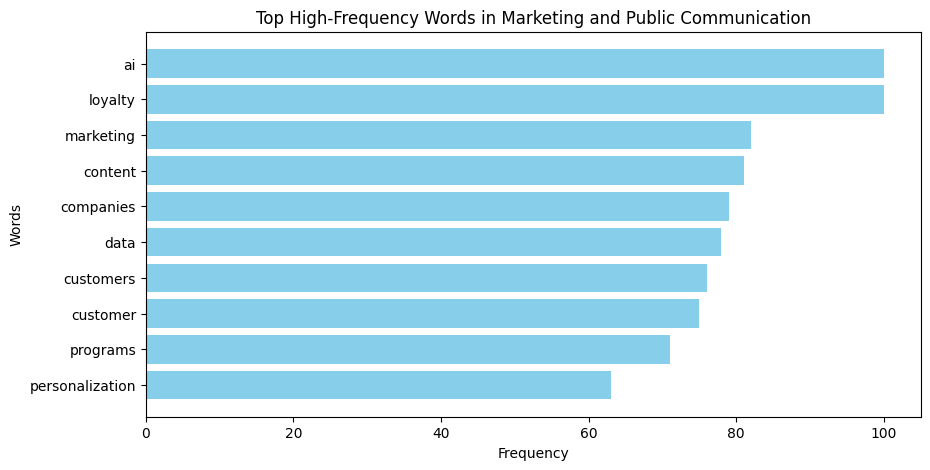

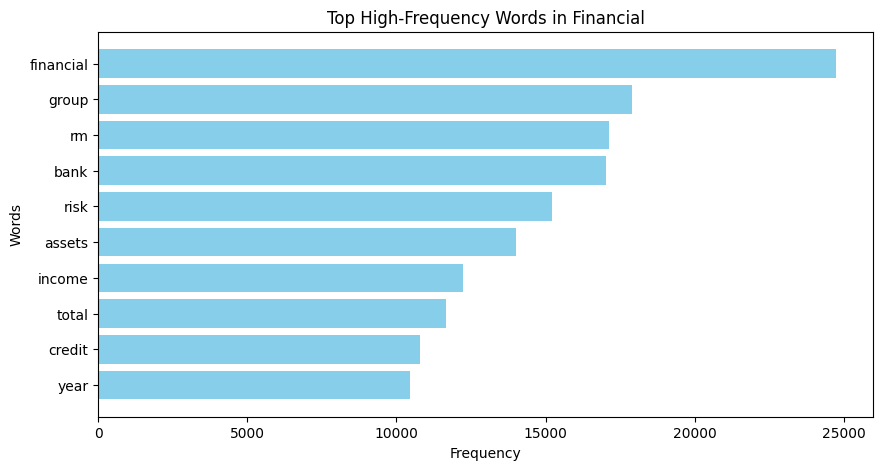

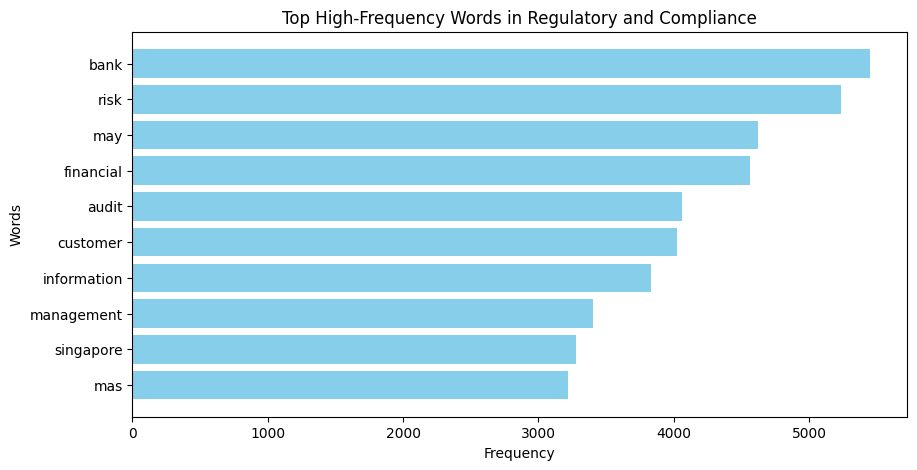

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Function to count word frequency
def count_word_frequency(text):
    words = text.split()
    return Counter(words)

# Compute word frequency for each topic in batches
word_freq_data = []
rare_word_data = []

for topic, text in combined_texts.items():
    word_counts = count_word_frequency(text)
    sorted_words = word_counts.most_common()

    # Extract top 20 high-frequency words
    for word, count in sorted_words[:20]:
        word_freq_data.append((topic, word, count))

    # Extract rare words (words appearing only once)
    rare_words = [word for word, count in sorted_words if count == 1]
    for word in rare_words[:20]:  # Limit rare words for efficiency
        rare_word_data.append((topic, word))

# Convert to DataFrame
word_freq_df = pd.DataFrame(word_freq_data, columns=["Topic", "Word", "Count"])
rare_word_df = pd.DataFrame(rare_word_data, columns=["Topic", "Rare Word"])

# Save CSVs to avoid reprocessing
word_freq_df.to_csv("high_frequency_words.csv", index=False)
rare_word_df.to_csv("rare_words.csv", index=False)

# Display sample tables for Jupyter Notebook
display(word_freq_df.head(20))  # Show first 20 high-frequency words
display(rare_word_df.head(20))  # Show first 20 rare words

# Generate bar charts for a subset of topics (prevents memory overload)
topics_to_plot = word_freq_df["Topic"].unique()[:3]  # Plot first 3 topics

for topic in topics_to_plot:
    df_topic = word_freq_df[word_freq_df["Topic"] == topic].nlargest(10, "Count")  # Top 10 words per topic

    if not df_topic.empty:
        plt.figure(figsize=(10, 5))
        plt.barh(df_topic["Word"], df_topic["Count"], color="skyblue")
        plt.xlabel("Frequency")
        plt.ylabel("Words")
        plt.title(f"Top High-Frequency Words in {topic}")
        plt.gca().invert_yaxis()
        plt.show()


### Comparing Rare Words vs High Frequency Words

Topic             Word  Count
0   Marketing and Public Communication               ai    100
1   Marketing and Public Communication          loyalty    100
2   Marketing and Public Communication        marketing     82
3   Marketing and Public Communication          content     81
4   Marketing and Public Communication        companies     79
5   Marketing and Public Communication             data     78
6   Marketing and Public Communication        customers     76
7   Marketing and Public Communication         customer     75
8   Marketing and Public Communication         programs     71
9   Marketing and Public Communication  personalization     63
10  Marketing and Public Communication            genai     58
11  Marketing and Public Communication         creative     53
12  Marketing and Public Communication              use     52
13  Marketing and Public Communication     personalized     47
14  Marketing and Public Communication           boston     42
15  Marketing and Public Communication       consulting     41
16  Marketing and Public Communication        consumers     41
17  Marketing and Public Communication          program     41
18  Marketing and Public Communication              new     40
19  Marketing and Public Communication          leaders     40

Topic         Rare Word
0   Marketing and Public Communication           thrived
1   Marketing and Public Communication           tripled
2   Marketing and Public Communication    bestperforming
3   Marketing and Public Communication         amaryllis
4   Marketing and Public Communication          liampoti
5   Marketing and Public Communication            moritz
6   Marketing and Public Communication            hagenm
7   Marketing and Public Communication              ller
8   Marketing and Public Communication               urs
9   Marketing and Public Communication             rahne
10  Marketing and Public Communication           sandeep
11  Marketing and Public Communication            ganapa
12  Marketing and Public Communication       hypergrowth
13  Marketing and Public Communication           soaring
14  Marketing and Public Communication            payers
15  Marketing and Public Communication               vcs
16  Marketing and Public Communication          speedier
17  Marketing and Public Communication      hyperscalers
18  Marketing and Public Communication        misaligned
19  Marketing and Public Communication  underrepresented

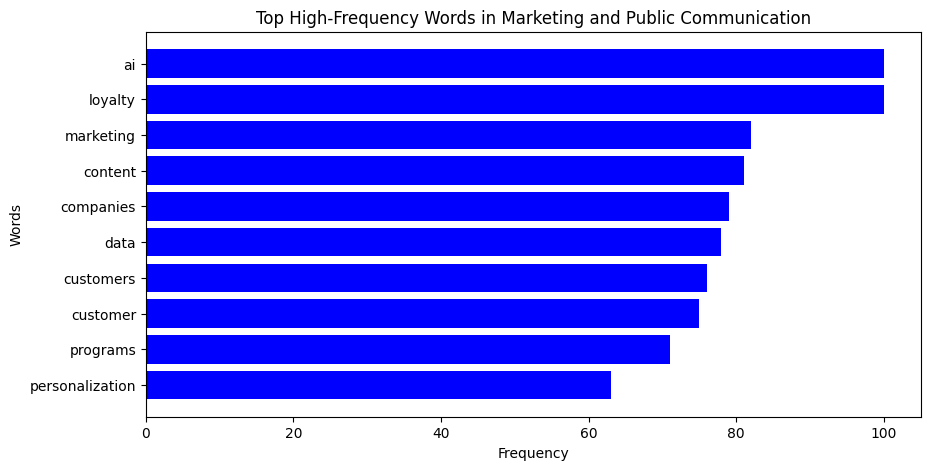

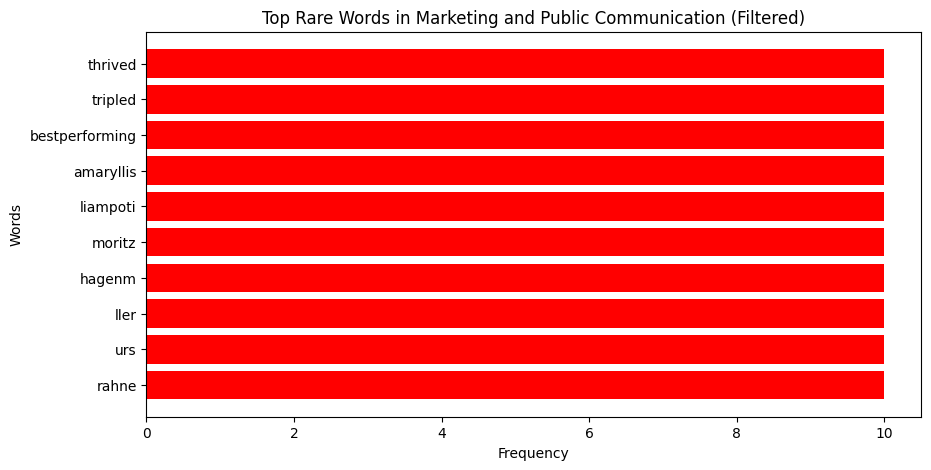

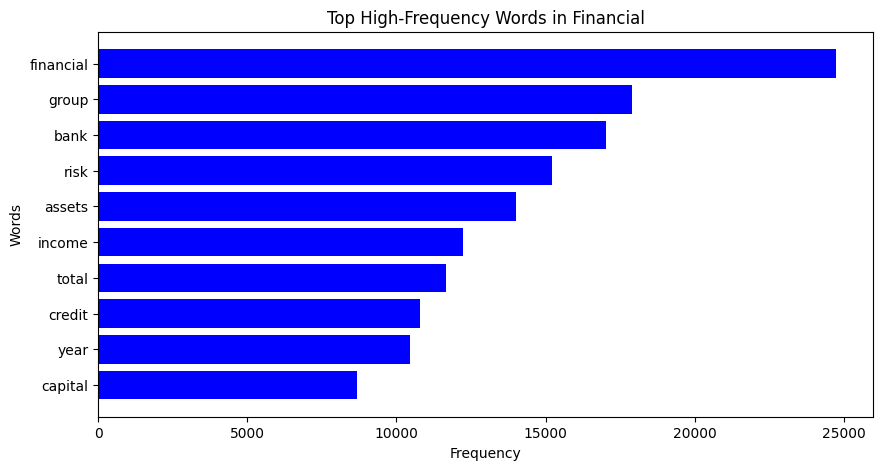

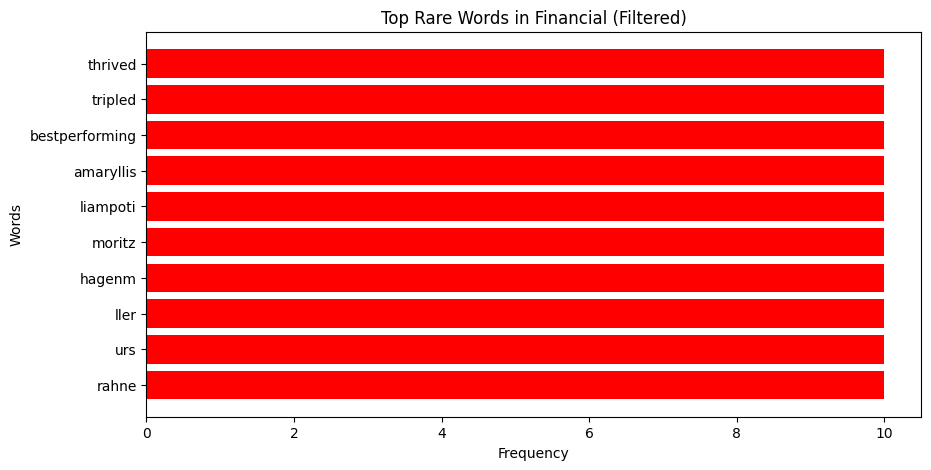

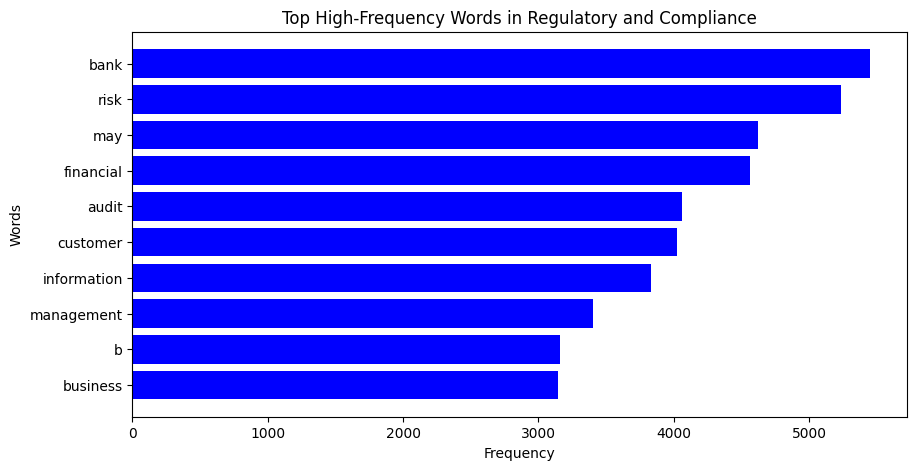

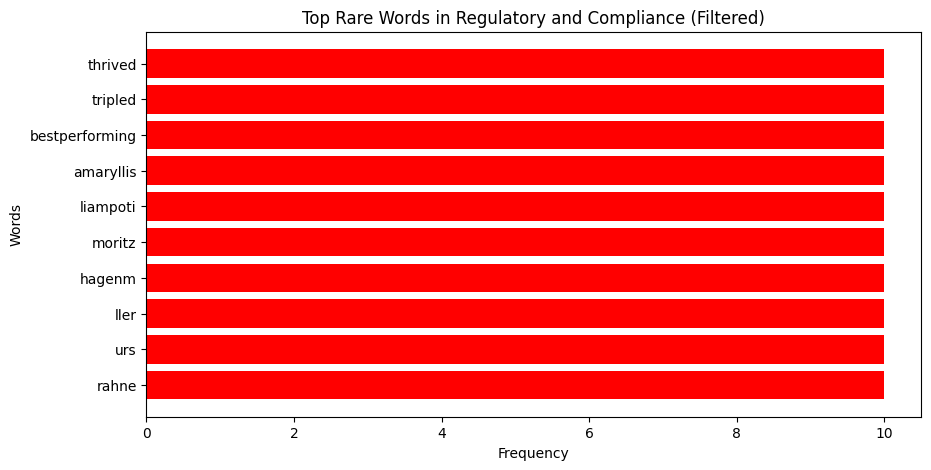

In [51]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Load SpaCy NLP model
nlp = spacy.load("en_core_web_sm")

# Increase SpaCy max length to avoid errors (but still use chunking)
nlp.max_length = 2_000_000  # Setting a higher limit, but chunking is still needed

# Define chunk size for processing large texts
CHUNK_SIZE = 500_000

# Define threshold for rare words
RARE_WORD_THRESHOLD = 10  # Words appearing <= 10 times

# Function to extract person names in chunks
def extract_person_names(text):
    person_names = set()
    text_length = len(text)

    for i in range(0, text_length, CHUNK_SIZE):
        chunk = text[i : i + CHUNK_SIZE]  # Process small chunks
        doc = nlp(chunk)
        person_names.update({ent.text.lower() for ent in doc.ents if ent.label_ == "PERSON"})

    return person_names

# Compute overall word frequency across all topics
word_freq_per_topic = {topic: Counter(text.split()) for topic, text in combined_texts.items()}
overall_word_counts = Counter()
for topic_counts in word_freq_per_topic.values():
    overall_word_counts.update(topic_counts)

# Extract names of people from the entire dataset
all_person_names = set()
for text in combined_texts.values():
    all_person_names.update(extract_person_names(text))  # Now processes in chunks

# Extract high-frequency and rare words, filtering out names
word_freq_data = []
rare_word_data = []

for topic, word_counts in word_freq_per_topic.items():
    sorted_words = word_counts.most_common()  # Sort words by frequency

    # Extract top 20 high-frequency words (excluding names)
    for word, count in sorted_words[:20]:
        if word not in all_person_names:  # Remove names
            word_freq_data.append((topic, word, count))

    # Extract rare words (words appearing <= threshold across all topics)
    rare_words = [word for word, count in overall_word_counts.items() if 2 <= count <= RARE_WORD_THRESHOLD]
    for word in rare_words[:20]:  # Limit rare words for visualization
        if word not in all_person_names:  # Remove names
            rare_word_data.append((topic, word))

# Create DataFrames
word_freq_df = pd.DataFrame(word_freq_data, columns=["Topic", "Word", "Count"])
rare_word_df = pd.DataFrame(rare_word_data, columns=["Topic", "Rare Word"])

# Save high-frequency and rare words to CSV
word_freq_df.to_csv("high_frequency_words.csv", index=False)
rare_word_df.to_csv("rare_words.csv", index=False)

# Display sample tables
display(word_freq_df.head(20))  # Show first 20 high-frequency words
display(rare_word_df.head(20))  # Show first 20 rare words

# Generate bar charts for selected topics
topics_to_plot = word_freq_df["Topic"].unique()[:3]  # Limit to 3 topics to prevent memory overload

for topic in topics_to_plot:
    df_high_freq = word_freq_df[word_freq_df["Topic"] == topic].nlargest(10, "Count")
    df_rare = rare_word_df[rare_word_df["Topic"] == topic].head(10)

    # High-Frequency Words Chart
    if not df_high_freq.empty:
        plt.figure(figsize=(10, 5))
        plt.barh(df_high_freq["Word"], df_high_freq["Count"], color="blue")
        plt.xlabel("Frequency")
        plt.ylabel("Words")
        plt.title(f"Top High-Frequency Words in {topic}")
        plt.gca().invert_yaxis()
        plt.show()

    # Rare Words Chart
    if not df_rare.empty:
        plt.figure(figsize=(10, 5))
        plt.barh(df_rare["Rare Word"], [RARE_WORD_THRESHOLD] * len(df_rare), color="red")
        plt.xlabel("Frequency")
        plt.ylabel("Words")
        plt.title(f"Top Rare Words in {topic} (Filtered)")
        plt.gca().invert_yaxis()
        plt.show()


### Generating output into csvs

In [39]:

# Save High-Frequency Words CSV
freq_words_df = pd.DataFrame.from_dict(
    {topic: dict(words) for topic, words in word_freq_per_topic.items()}, orient='index'
).fillna(0)

freq_words_df.to_csv("high_frequency_words.csv")

# Save TF-IDF Words CSV
tfidf_df.to_csv("tfidf_words.csv")

# Save Rare Words CSV
rare_words_df = pd.DataFrame.from_dict(rare_words, orient='index').transpose()
rare_words_df.to_csv("rare_words.csv")

print("✅ CSV files generated successfully!")


✅ CSV files generated successfully!


### Rule Based (in-progress)

In [ ]:
import re
from collections import defaultdict

# Define patterns to check for section headers
section_patterns = ["introduction", "conclusion", "loan terms", "employment details", "confidentiality clause"]

# Function to find section headers in text
def find_section_headers(text):
    found_headers = [header for header in section_patterns if re.search(rf"\b{header}\b", text, re.IGNORECASE)]
    return found_headers

# Check for section headers in each topic
header_results = defaultdict(list)
for topic, text in combined_texts.items():
    found_headers = find_section_headers(text)
    header_results[topic] = found_headers

# Print results
print("\nIdentified Section Headers Per Topic:")
for topic, headers in header_results.items():
    print(f"{topic}: {headers}")


# Goal: Determine Whether Introduction and Conclusion are Sufficient for Classification

In this section, we seek to explore whether we can streamline the process by only passing in the introduction or conclusion, rather than having to pass in the entire documents, which might be lengthy (some up to 400 pages). If this is possible, the efficiency of the algorithm would be improved and savings in costs will also be experienced.

In [5]:
def extract_intro_conclusion(text):
    words = text.split()
    total_words = len(words)

    # Adjust intro/conclusion length dynamically based on document size
    if total_words < 1000:
        intro_ratio, conclusion_ratio = 0.15, 0.15  # 15% for short docs
    elif total_words < 10000:
        intro_ratio, conclusion_ratio = 0.07, 0.07  # 7% for medium docs
    elif total_words < 50000:
        intro_ratio, conclusion_ratio = 0.03, 0.03  # 3% for long docs
    else:
        intro_ratio, conclusion_ratio = 0.01, 0.01  # 1% for very long docs

    # Ensure we extract at least 50 words (for very small docs)
    min_length = 50
    intro_end = max(int(total_words * intro_ratio), min_length)
    conclusion_start = max(int(total_words * (1 - conclusion_ratio)), total_words - min_length)

    intro_text = " ".join(words[:intro_end])
    conclusion_text = " ".join(words[conclusion_start:])

    return intro_text, conclusion_text

# Apply to all topics
intro_conclusion_texts = {topic: extract_intro_conclusion(text) for topic, text in combined_texts.items()}


## Word Overlap Analysis

In [6]:
# Store word overlap results
overlap_results = []

for topic, text in combined_texts.items():
    intro, conclusion = extract_intro_conclusion(text)
    
    full_words = set(text.split())
    intro_words = set(intro.split())
    conclusion_words = set(conclusion.split())

    intro_overlap = len(intro_words & full_words) / len(full_words)
    conclusion_overlap = len(conclusion_words & full_words) / len(full_words)

    overlap_results.append([topic, intro_overlap, conclusion_overlap])

# Convert to DataFrame
df_overlap = pd.DataFrame(overlap_results, columns=["Topic", "Intro Overlap", "Conclusion Overlap"])

# Save results
df_overlap.to_csv("word_overlap_analysis.csv", index=False)

# Print results
print(df_overlap)


                                Topic  Intro Overlap  Conclusion Overlap
0  Marketing and Public Communication       0.144756            0.016248
1                           Financial       0.114626            0.001762
2           Regulatory and Compliance       0.095931            0.002514
3                          Technology       0.046548            0.001206
4               Legal and Contractual       0.078174            0.003431
5                           Strategic       0.037505            0.004569
6                      Administrative       0.074445            0.013601
7                         Operational       0.095621            0.006792


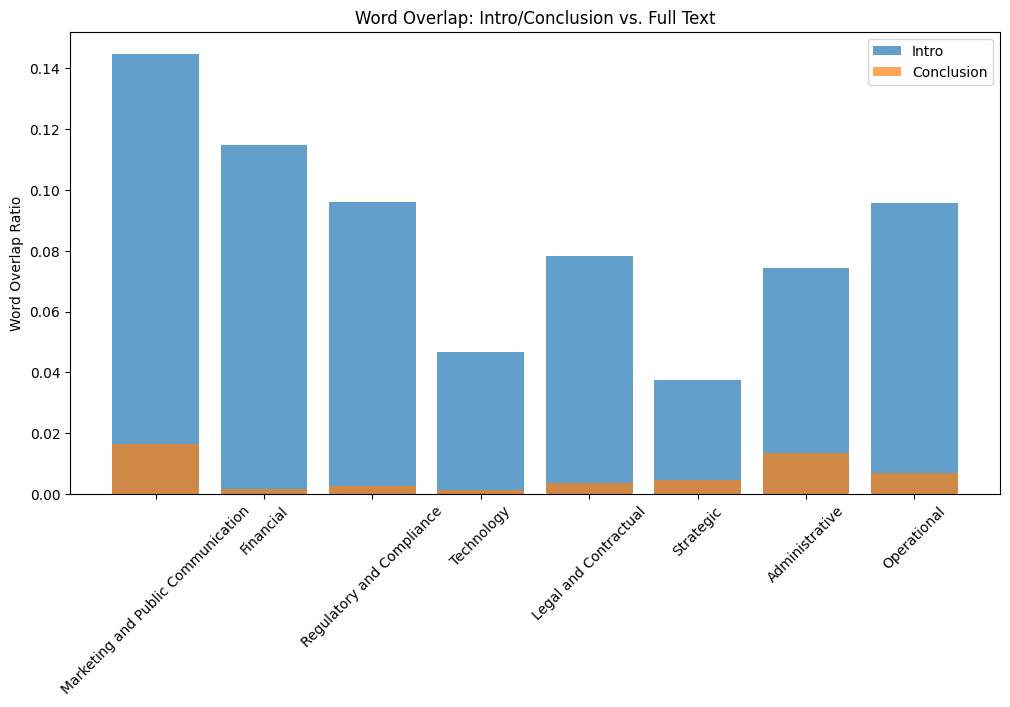

In [7]:
plt.figure(figsize=(12, 6))
plt.bar(df_overlap["Topic"], df_overlap["Intro Overlap"], label="Intro", alpha=0.7)
plt.bar(df_overlap["Topic"], df_overlap["Conclusion Overlap"], label="Conclusion", alpha=0.7)
plt.xticks(rotation=45)
plt.ylabel("Word Overlap Ratio")
plt.title("Word Overlap: Intro/Conclusion vs. Full Text")
plt.legend()
plt.show()


## Tf-IDF Similarity Analysis

In [10]:
tfidf_vectorizer = TfidfVectorizer()

# Store similarity scores and TF-IDF values
similarity_results = []
tfidf_scores = []

for topic, text in combined_texts.items():
    intro, conclusion = extract_intro_conclusion(text)  # Dynamic extraction

    # List of documents for TF-IDF
    docs = [intro, conclusion, text]  # Only Intro, Conclusion, and Full Text
    tfidf_matrix = tfidf_vectorizer.fit_transform(docs)  # Convert to TF-IDF

    # Compute cosine similarity
    intro_sim = cosine_similarity(tfidf_matrix[0], tfidf_matrix[2])[0][0]  # Intro vs Full
    conclusion_sim = cosine_similarity(tfidf_matrix[1], tfidf_matrix[2])[0][0]  # Conclusion vs Full
    intro_conclusion_sim = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])[0][0]  # Intro vs Conclusion

    # Get top 10 TF-IDF words for each section
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    def get_top_tfidf_words(tfidf_array):
        return sorted(zip(feature_names, tfidf_array), key=lambda x: x[1], reverse=True)[:10]

    intro_tfidf_scores = get_top_tfidf_words(tfidf_matrix.toarray()[0])
    conclusion_tfidf_scores = get_top_tfidf_words(tfidf_matrix.toarray()[1])
    full_tfidf_scores = get_top_tfidf_words(tfidf_matrix.toarray()[2])

    similarity_results.append([topic, intro_sim, conclusion_sim, intro_conclusion_sim])
    tfidf_scores.append([topic, intro_tfidf_scores, conclusion_tfidf_scores, full_tfidf_scores])

# Convert to DataFrame for similarity results
df_similarity = pd.DataFrame(similarity_results, 
                             columns=["Topic", "Intro Similarity", "Conclusion Similarity", "Intro vs Conclusion Similarity"])
df_similarity.to_csv("tfidf_similarity_analysis.csv", index=False)

# Convert to DataFrame for TF-IDF scores
df_tfidf = pd.DataFrame(tfidf_scores, 
                        columns=["Topic", "Intro TF-IDF", "Conclusion TF-IDF", "Full Text TF-IDF"])
df_tfidf.to_csv("tfidf_top_words.csv", index=False)

# Print results
print("\n🔹 TF-IDF Similarity Scores:")
print(df_similarity)

print("\n🔹 Top TF-IDF Words Per Section:")
print(df_tfidf)



🔹 TF-IDF Similarity Scores:
                                Topic  Intro Similarity  \
0  Marketing and Public Communication          0.403282   
1                           Financial          0.558840   
2           Regulatory and Compliance          0.458854   
3                          Technology          0.410518   
4               Legal and Contractual          0.374976   
5                           Strategic          0.448657   
6                      Administrative          0.479142   
7                         Operational          0.176636   

   Conclusion Similarity  Intro vs Conclusion Similarity  
0               0.152504                        0.026900  
1               0.099098                        0.071256  
2               0.155308                        0.029396  
3               0.034671                        0.066606  
4               0.042661                        0.047210  
5               0.071389                        0.022139  
6               0.169440  

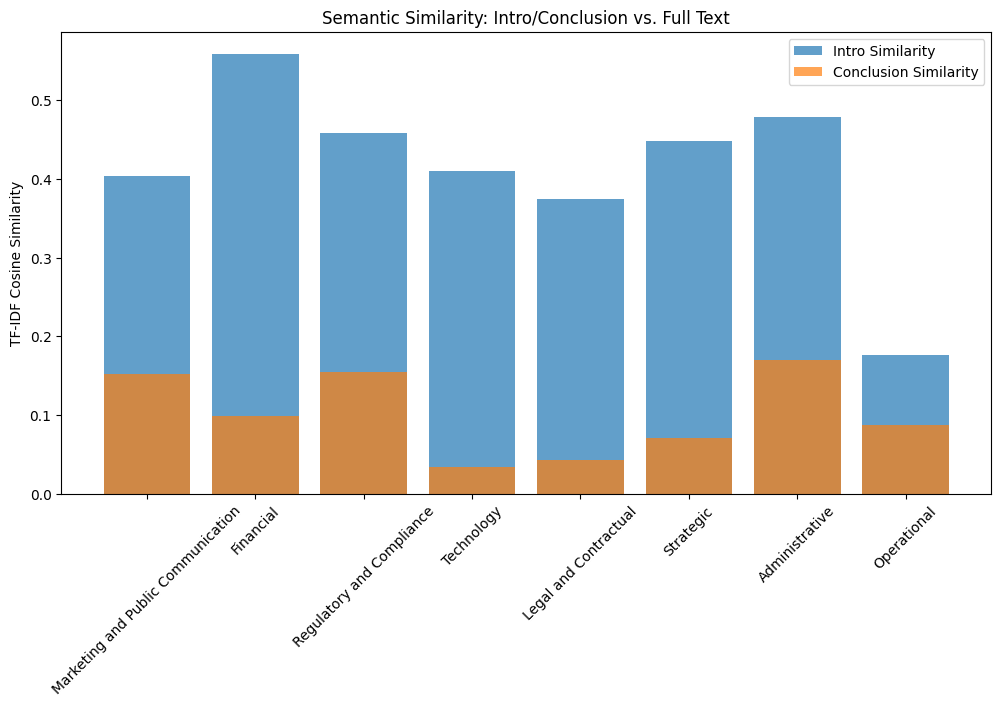

In [11]:
plt.figure(figsize=(12, 6))
plt.bar(df_similarity["Topic"], df_similarity["Intro Similarity"], label="Intro Similarity", alpha=0.7)
plt.bar(df_similarity["Topic"], df_similarity["Conclusion Similarity"], label="Conclusion Similarity", alpha=0.7)
plt.xticks(rotation=45)
plt.ylabel("TF-IDF Cosine Similarity")
plt.title("Semantic Similarity: Intro/Conclusion vs. Full Text")
plt.legend()
plt.show()